# Imports

In [1]:
import os
import logging
import sys
import inspect
from copy import copy

currentdir = os.path.dirname(os.path.abspath(inspect.getfile(inspect.currentframe())))
parentdir = os.path.dirname(currentdir)
sys.path.insert(0, parentdir)

import itertools
import pandas as pd
import random
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.data as data
import torch.distributions as dist
import torch.optim as optim
from torch.optim import Adam, RMSprop
import torch.utils.data
from sklearn.model_selection import train_test_split
from tqdm.auto import tqdm
import npyx.c4.dl_utils as m

from npyx.c4.dataset_init import WAVEFORM_SAMPLES
from npyx.datasets import LABELLING, CORRESPONDENCE
import npyx.c4.dl_transforms as custom_transforms
from npyx.c4.dl_utils import ELBO_VAE, generate_kl_weight
import torchvision.transforms as transforms

from pathlib import Path
from sklearn.metrics import f1_score, confusion_matrix
import matplotlib.pyplot as plt
import matplotlib.patches as patches

import npyx

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

%load_ext autoreload
%autoreload 2


cupy could not be imported - some functions dealing with the binary file (filtering, whitening...) will not work.

npyx version 3.0.0 imported.


Set seed and constants

In [2]:
home = str(Path.home())
PATH = os.path.dirname(os.path.abspath(""))
DEVICE = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
SEED = 1234
USE_CUDA = torch.cuda.is_available()
INIT_WEIGHTS = False

npyx.ml.set_seed(SEED)
torch.set_default_dtype(torch.float32)

Random seed 1234 has been set.


In [3]:
N_CHANNELS = 4

# Data 

Here we specify in which directory the `.h5` datasets are located, and read the hausser, hull and hull unlabelled datasets.
Note that the hull labelled dataset is read every time by default but the labelled neurons will be discarded later.

In [4]:
DATASETS_DIRECTORY = "/home/npyx/Desktop/C4_data_final_23_07_26/"

In [5]:
dataset_paths = npyx.c4.get_paths_from_dir(DATASETS_DIRECTORY, include_hull_unlab=True)

# Normalise waveforms so that the max in the dataset is 1 and the minimum is -1. Only care about shape.
BASE_DATASET = npyx.c4.extract_and_merge_datasets(
    *dataset_paths,
    quality_check=False,
    normalise_wvf=False,  # Will do later
    _use_amplitudes=False,
    n_channels=N_CHANNELS,
    central_range=WAVEFORM_SAMPLES,
    labelled=False,
)

Loading dataset /home/npyx/Desktop/C4_data_final_23_07_26/C4_database_hull_labelled.h5


Reading dataset:   0%|          | 0/103 [00:00<?, ?it/s]

0 unlabelled and 103 labelled neurons loaded. 
0 neurons discarded, of which labelled: 0. More details at the 'discarded_df' attribute. 

Loading dataset /home/npyx/Desktop/C4_data_final_23_07_26/C4_database_hull_unlabelled.h5


Reading dataset:   0%|          | 0/1425 [00:00<?, ?it/s]

1425 unlabelled and 0 labelled neurons loaded. 
0 neurons discarded, of which labelled: 0. More details at the 'discarded_df' attribute. 

Loading dataset /home/npyx/Desktop/C4_data_final_23_07_26/C4_database_hausser.h5


Reading dataset:   0%|          | 0/1998 [00:00<?, ?it/s]

1885 unlabelled and 113 labelled neurons loaded. 
0 neurons discarded, of which labelled: 0. More details at the 'discarded_df' attribute. 



We make the dataset unlabelled, as we do not want the labelled data to be seen at this step.

We also define a `DATASET_LEN` variable which is going to be used in the ELBO loss function to scale the loss.

In [6]:
BASE_DATASET.make_unlabelled_only()
DATASET_LEN = len(BASE_DATASET)

In [7]:
DATASET_LEN

3310

Next we create a PyTorch `data.Dataset` class which is going to work with the DataLoader during training to get batches of data.

We also initialise data augmentations.

In [8]:
class CerebellumDataset(data.Dataset):
    """Dataset of waveforms as images. Every batch will have shape:
    (batch_size, 1, N_CHANNELS, WAVEFORM_SAMPLES)"""

    def __init__(
        self, data: np.ndarray, labels: np.ndarray, raw_spikes: list, transform=None
    ):
        """
        Args:
            data (ndarray): Array of data points, with wvf and acg concatenated
            labels (string): Array of labels for the provided data
            raw_spikes (ndarray): Array of raw spikes for the provided data
        """
        self.data = data
        self.labels = labels
        self.transform = transform
        self.spikes = raw_spikes

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()
        data_point = self.data[idx, :].astype("float32").reshape(1, -1)
        label = self.labels[idx]
        spikes = self.spikes[idx].astype("int")
        sample = (data_point, label)

        if self.transform:
            sample, spikes = self.transform(sample, spikes)
        return sample

Compute the conformed waveforms (flipped according to most prominent peak and normalised)

In [9]:
waveforms = []
for wf in BASE_DATASET.wf:
    waveform = npyx.datasets.preprocess_template(wf.reshape(N_CHANNELS, -1)).ravel()
    waveforms.append(waveform)
waveforms = np.stack(waveforms, axis=0)

In [10]:
# Add augmentation transforms if wanted
composed = custom_transforms.CustomCompose(
    [
        custom_transforms.SwapChannels(p=0.5),
        custom_transforms.VerticalReflection(p=0.5),
        custom_transforms.PermuteChannels(p=0.1, n_channels=2),
        custom_transforms.HorizontalCompression(p=0.5),
    ]
)
dataset = CerebellumDataset(
    waveforms, BASE_DATASET.targets, BASE_DATASET.spikes_list, transform=composed
)
train_loader = data.DataLoader(dataset, batch_size=64, shuffle=True)

In [15]:
test_model = nn.Sequential(
    nn.Conv2d(1, 4, kernel_size=(1, 8)),
    nn.AvgPool2d((1, 2)),
    nn.Conv2d(4, 8, kernel_size=(3, 1)),
    nn.AvgPool2d((1, 2)),
)

In [16]:
test_model(torch.randn(1, 1, 4, 90)).shape

torch.Size([1, 8, 2, 20])

# Models

Here we redefine the constant variable WAVEFORM_SAMPLES to 90 because that is the value it will be after the `ConformWaveform` transformation

In [17]:
WAVEFORM_SAMPLES = 90

In [18]:
class Encoder(nn.Module):
    def __init__(self, d_latent, initialise=False):
        super().__init__()
        # self.resize = transforms.Resize((WAVEFORM_SAMPLES, WAVEFORM_SAMPLES))
        # self.conv1 = nn.Conv2d(1, 8, 3)
        # self.conv1 = nn.Conv2d(1, 8, kernel_size=(4, 1))
        self.conv1 = nn.Conv2d(1, 4, kernel_size=(1, 8))
        # self.maxpool1 = nn.AvgPool2d(3)
        # self.maxpool1 = nn.AvgPool2d(2)
        self.maxpool1 = nn.AvgPool2d((1, 2))

        self.batchnorm1 = nn.BatchNorm2d(4)
        # self.conv2 = nn.Conv2d(8, 16, 3)
        # self.conv2 = nn.Conv2d(8, 16, kernel_size=(1, 6))
        self.conv2 = nn.Conv2d(4, 8, kernel_size=(3, 1))

        # self.maxpool2 = nn.AvgPool2d(2)
        self.maxpool2 = nn.AvgPool2d((1, 2))

        # self.maxpool2 = nn.AvgPool2d(3)
        self.batchnorm2 = nn.BatchNorm2d(8)
        self.flatten = nn.Flatten()
        # self.fc1 = nn.Linear(16 * 5 * 5, d_latent * 2)
        self.fc1 = nn.Linear(8 * 2 * 20, d_latent * 2)

        self.d_latent = d_latent
        self.dropout = nn.Dropout(0.2)

        # self.fctest = nn.Sequential(
        #     nn.Flatten(),
        #     nn.Linear(WAVEFORM_SAMPLES * N_CHANNELS, 400),
        #     nn.GELU(),
        #     nn.Linear(400, 200),
        #     nn.GELU(),
        #     nn.Linear(200, 2 * d_latent),
        # )

        if initialise:
            self.conv1.weight.data.normal_(0, 0.001)
            self.conv1.bias.data.normal_(0, 0.001)

            self.conv2.weight.data.normal_(0, 0.001)
            self.conv2.bias.data.normal_(0, 0.001)

            self.fc1.weight.data.normal_(0, 0.001)
            self.fc1.bias.data.normal_(0, 0.001)

    def forward(self, x):
        # x = self.resize(x)
        x = self.conv1(x)
        x = F.gelu(self.maxpool1(x))
        x = self.batchnorm1(x)
        x = self.conv2(x)
        x = F.gelu(self.maxpool2(x))
        x = self.batchnorm2(x)
        x = self.flatten(x)
        h = self.dropout(self.fc1(x))
        # h = self.dropout(self.fctest(x))
        # split the output into mu and log_var
        mu = h[:, : self.d_latent]
        log_var = h[:, self.d_latent :]
        # return mu and log_var
        return dist.Normal(mu, torch.exp(log_var))


class Decoder(nn.Module):
    def __init__(self, d_latent, initialise=False):
        super().__init__()
        self.d_latent = d_latent
        self.fc1 = nn.Linear(d_latent, 200)
        self.fc2 = nn.Linear(200, 400)
        self.fc3 = nn.Linear(400, (N_CHANNELS * WAVEFORM_SAMPLES))

        self.dropout1 = nn.Dropout(0.2)
        self.dropout2 = nn.Dropout(0.2)

        if initialise:
            self.fc1.weight.data.normal_(0, 0.001)
            self.fc1.bias.data.normal_(0, 0.001)

            self.fc2.weight.data.normal_(0, 0.001)
            self.fc2.bias.data.normal_(0, 0.001)

            self.fc3.weight.data.normal_(0, 0.001)
            self.fc3.bias.data.normal_(0, 0.001)

    def forward(self, z):
        # flatten the latent vector
        z = z.view(z.shape[0], -1)
        h = self.dropout1(F.relu(self.fc1(z)))
        h = self.dropout2(F.relu(self.fc2(h)))
        X_reconstructed = self.fc3(h)

        return X_reconstructed.reshape(-1, 1, N_CHANNELS, WAVEFORM_SAMPLES)

# Choose parameters and train

In [19]:
BETA = 5
D_LATENT = 10

In [21]:
npyx.ml.set_seed(SEED)
torch.cuda.empty_cache()
initialise = True
enc, dec = Encoder(D_LATENT, initialise), Decoder(D_LATENT, initialise)
enc.to(DEVICE)
dec.to(DEVICE)
enc.train()
dec.train()

lr = 1e-3
optim_args = {
    "params": itertools.chain(enc.parameters(), dec.parameters()),
    "lr": lr,
}
opt_vae = optim.Adam(**optim_args)

scheduler = torch.optim.lr_scheduler.CosineAnnealingWarmRestarts(
    opt_vae, 30, 1, last_epoch=-1
)

N_epochs = 150
losses = []

kl_weights = generate_kl_weight(N_epochs, beta=BETA)


for epoch in tqdm(range(N_epochs), desc="Epochs"):
    train_loss = 0.0
    for X, _ in train_loader:
        X = X.to(DEVICE)
        X = X.reshape(-1, 1, N_CHANNELS, WAVEFORM_SAMPLES)
        opt_vae.zero_grad()
        loss = ELBO_VAE(
            enc, dec, X, dataset_size=DATASET_LEN, beta=kl_weights[epoch], device=DEVICE
        )
        loss.backward()
        opt_vae.step()
        train_loss += loss.item() * X.shape[0] / len(BASE_DATASET)
    scheduler.step()
    losses.append(train_loss)

Random seed 1234 has been set.


Epochs:   0%|          | 0/150 [00:00<?, ?it/s]

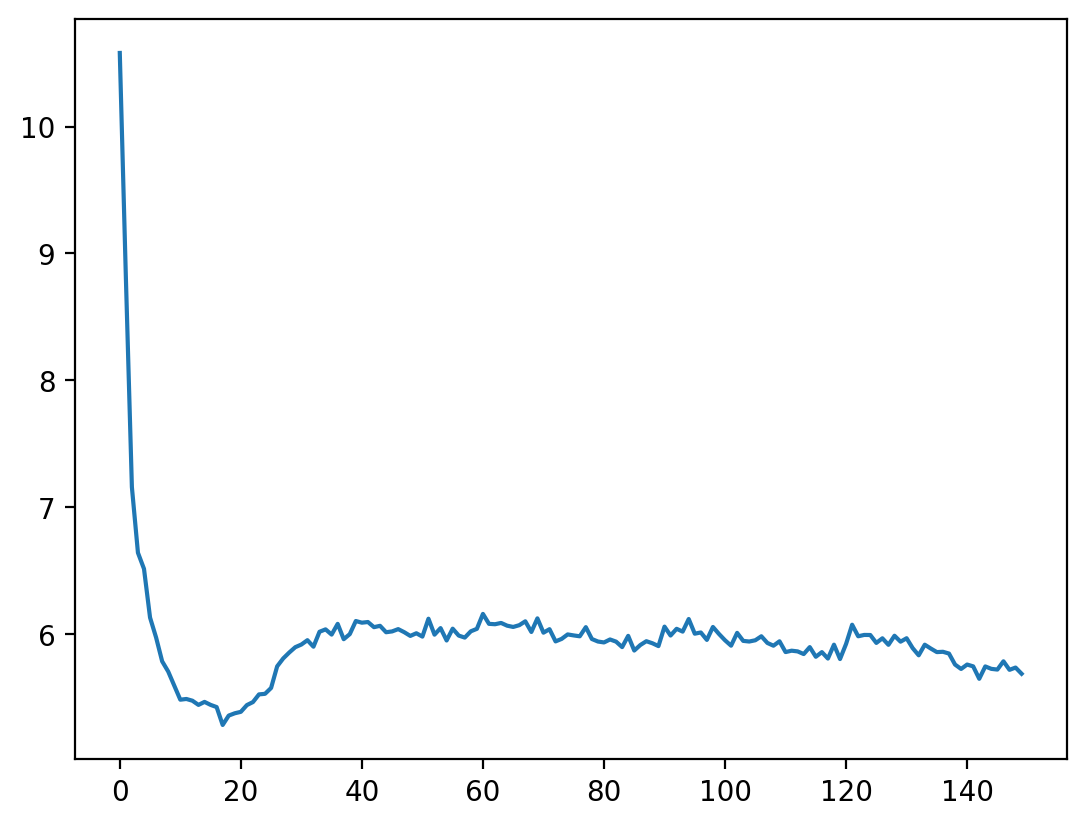

In [22]:
plt.plot(losses)

In [23]:
def plot_random_reconstruction(
    full_dataset, enc, dec, dataset_info, n_neurons=1, label=None
):
    """
    Plots a random neuron from the dataset. Optionally, can specify a label
    """
    if label is not None:
        if label in CORRESPONDENCE:
            mask = full_dataset[:, 0] == label
            full_dataset = full_dataset[mask, :]
        elif label in LABELLING:
            mask = full_dataset[:, 0] == LABELLING[label]
            full_dataset = full_dataset[mask, :]
        else:
            return "Invalid label"

    if n_neurons > full_dataset.shape[0]:
        print(
            f"Only {full_dataset.shape[0]} neurons to plot with the provided parameter choice"
        )
        n_neurons = full_dataset.shape[0]

    idx = np.random.choice(range(full_dataset.shape[0]), n_neurons, replace=False)
    for i in idx:
        fig, axs = plt.subplots(2, 3, figsize=(12, 6), constrained_layout=True)
        fig.suptitle(
            r"$\bf{"
            + CORRESPONDENCE[full_dataset[i, 0]]
            + "}$ - "
            + "Dataset: "
            + dataset_info[i]
        )
        wf_original = full_dataset[i, 1:].reshape(N_CHANNELS, WAVEFORM_SAMPLES)

        axs[0, 0].imshow(wf_original, interpolation="nearest", aspect="auto")
        rect = patches.Rectangle(
            (0, N_CHANNELS // 2 - 0.5),
            WAVEFORM_SAMPLES - 1,
            1,
            linewidth=1,
            edgecolor="r",
            facecolor="none",
        )

        axs[0, 0].add_patch(rect)
        axs[0, 0].set_title("Original raw waveform across channels")

        n_lines = wf_original.shape[0]
        x = range(wf_original.shape[1])
        linewidth = 4
        for j, row in enumerate(wf_original):
            if j == N_CHANNELS // 2:
                line = row + (n_lines - j)
                axs[0, 1].plot(
                    x, line, lw=linewidth, c="red", alpha=1, zorder=j / n_lines
                )
            # elif i % 2 == 0:
            #     continue
            else:
                line = row + (n_lines - j)
                axs[0, 1].plot(
                    x, line, lw=linewidth, c="grey", alpha=1, zorder=j / n_lines
                )
        axs[0, 1].set_title("Original Raw waveforms")
        axs[0, 1].set_yticks([])

        axs[0, 2].plot(wf_original[N_CHANNELS // 2, :])
        axs[0, 2].set_title("Original Peak channel waveform")

        with torch.no_grad():
            network_input = torch.Tensor(
                full_dataset[i, 1:]
                .reshape(1, 1, N_CHANNELS, WAVEFORM_SAMPLES)
                .astype(np.float32)
            )
            # wf_reconstructed = dec(enc(network_input).sample()).mean.reshape(N_CHANNELS, WAVEFORM_SAMPLES).detach().numpy()
            wf_reconstructed = (
                dec(enc(network_input).mean)
                .reshape(N_CHANNELS, WAVEFORM_SAMPLES)
                .detach()
                .numpy()
            )

        axs[1, 0].imshow(wf_reconstructed, interpolation="nearest", aspect="auto")
        rect = patches.Rectangle(
            (0, N_CHANNELS // 2 - 0.5),
            WAVEFORM_SAMPLES - 1,
            1,
            linewidth=1,
            edgecolor="r",
            facecolor="none",
        )

        axs[1, 0].add_patch(rect)
        axs[1, 0].set_title("Reconstructed raw waveform across channels")

        n_lines = wf_reconstructed.shape[0]
        x = range(wf_reconstructed.shape[1])
        linewidth = 4
        for i, row in enumerate(wf_reconstructed):
            if i == N_CHANNELS // 2:
                line = row + (n_lines - i)
                axs[1, 1].plot(
                    x, line, lw=linewidth, c="red", alpha=1, zorder=i / n_lines
                )
            # elif i % 2 == 0:
            #     continue
            else:
                line = row + (n_lines - i)
                axs[1, 1].plot(
                    x, line, lw=linewidth, c="grey", alpha=1, zorder=i / n_lines
                )
        axs[1, 1].set_title("Reconstructed Raw waveforms")
        axs[1, 1].set_yticks([])

        axs[1, 2].plot(wf_reconstructed[N_CHANNELS // 2, :])
        axs[1, 2].set_title("Reconstructed Peak channel waveform")

        plt.show()

In [24]:
enc.cpu().eval()
dec.cpu().eval()

Decoder(
  (fc1): Linear(in_features=10, out_features=200, bias=True)
  (fc2): Linear(in_features=200, out_features=400, bias=True)
  (fc3): Linear(in_features=400, out_features=360, bias=True)
  (dropout1): Dropout(p=0.2, inplace=False)
  (dropout2): Dropout(p=0.2, inplace=False)
)

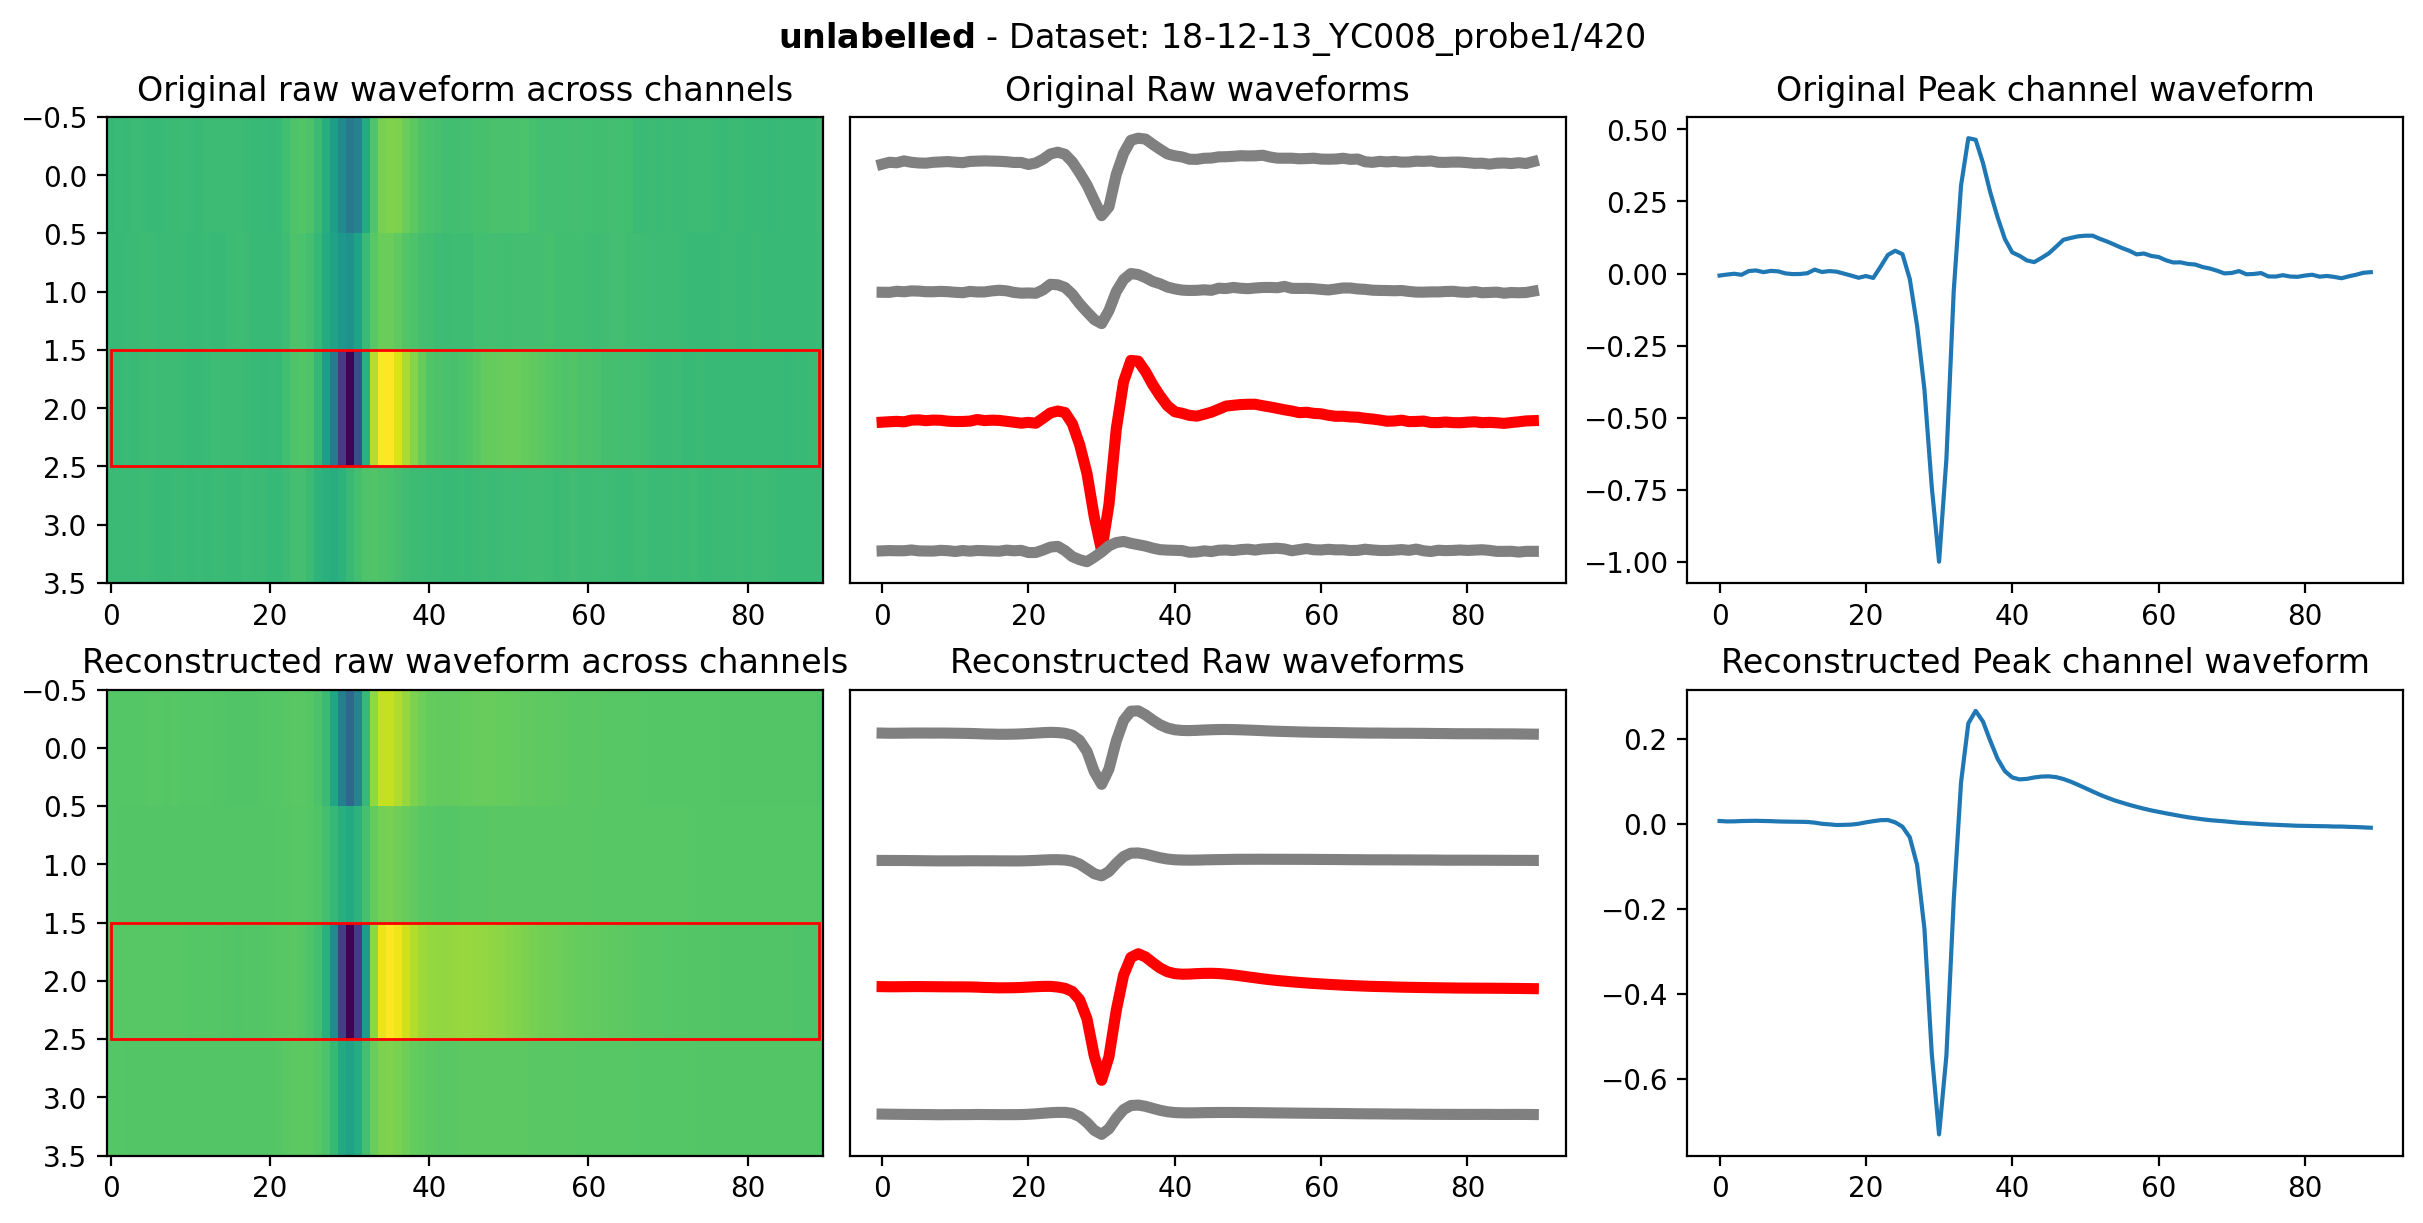

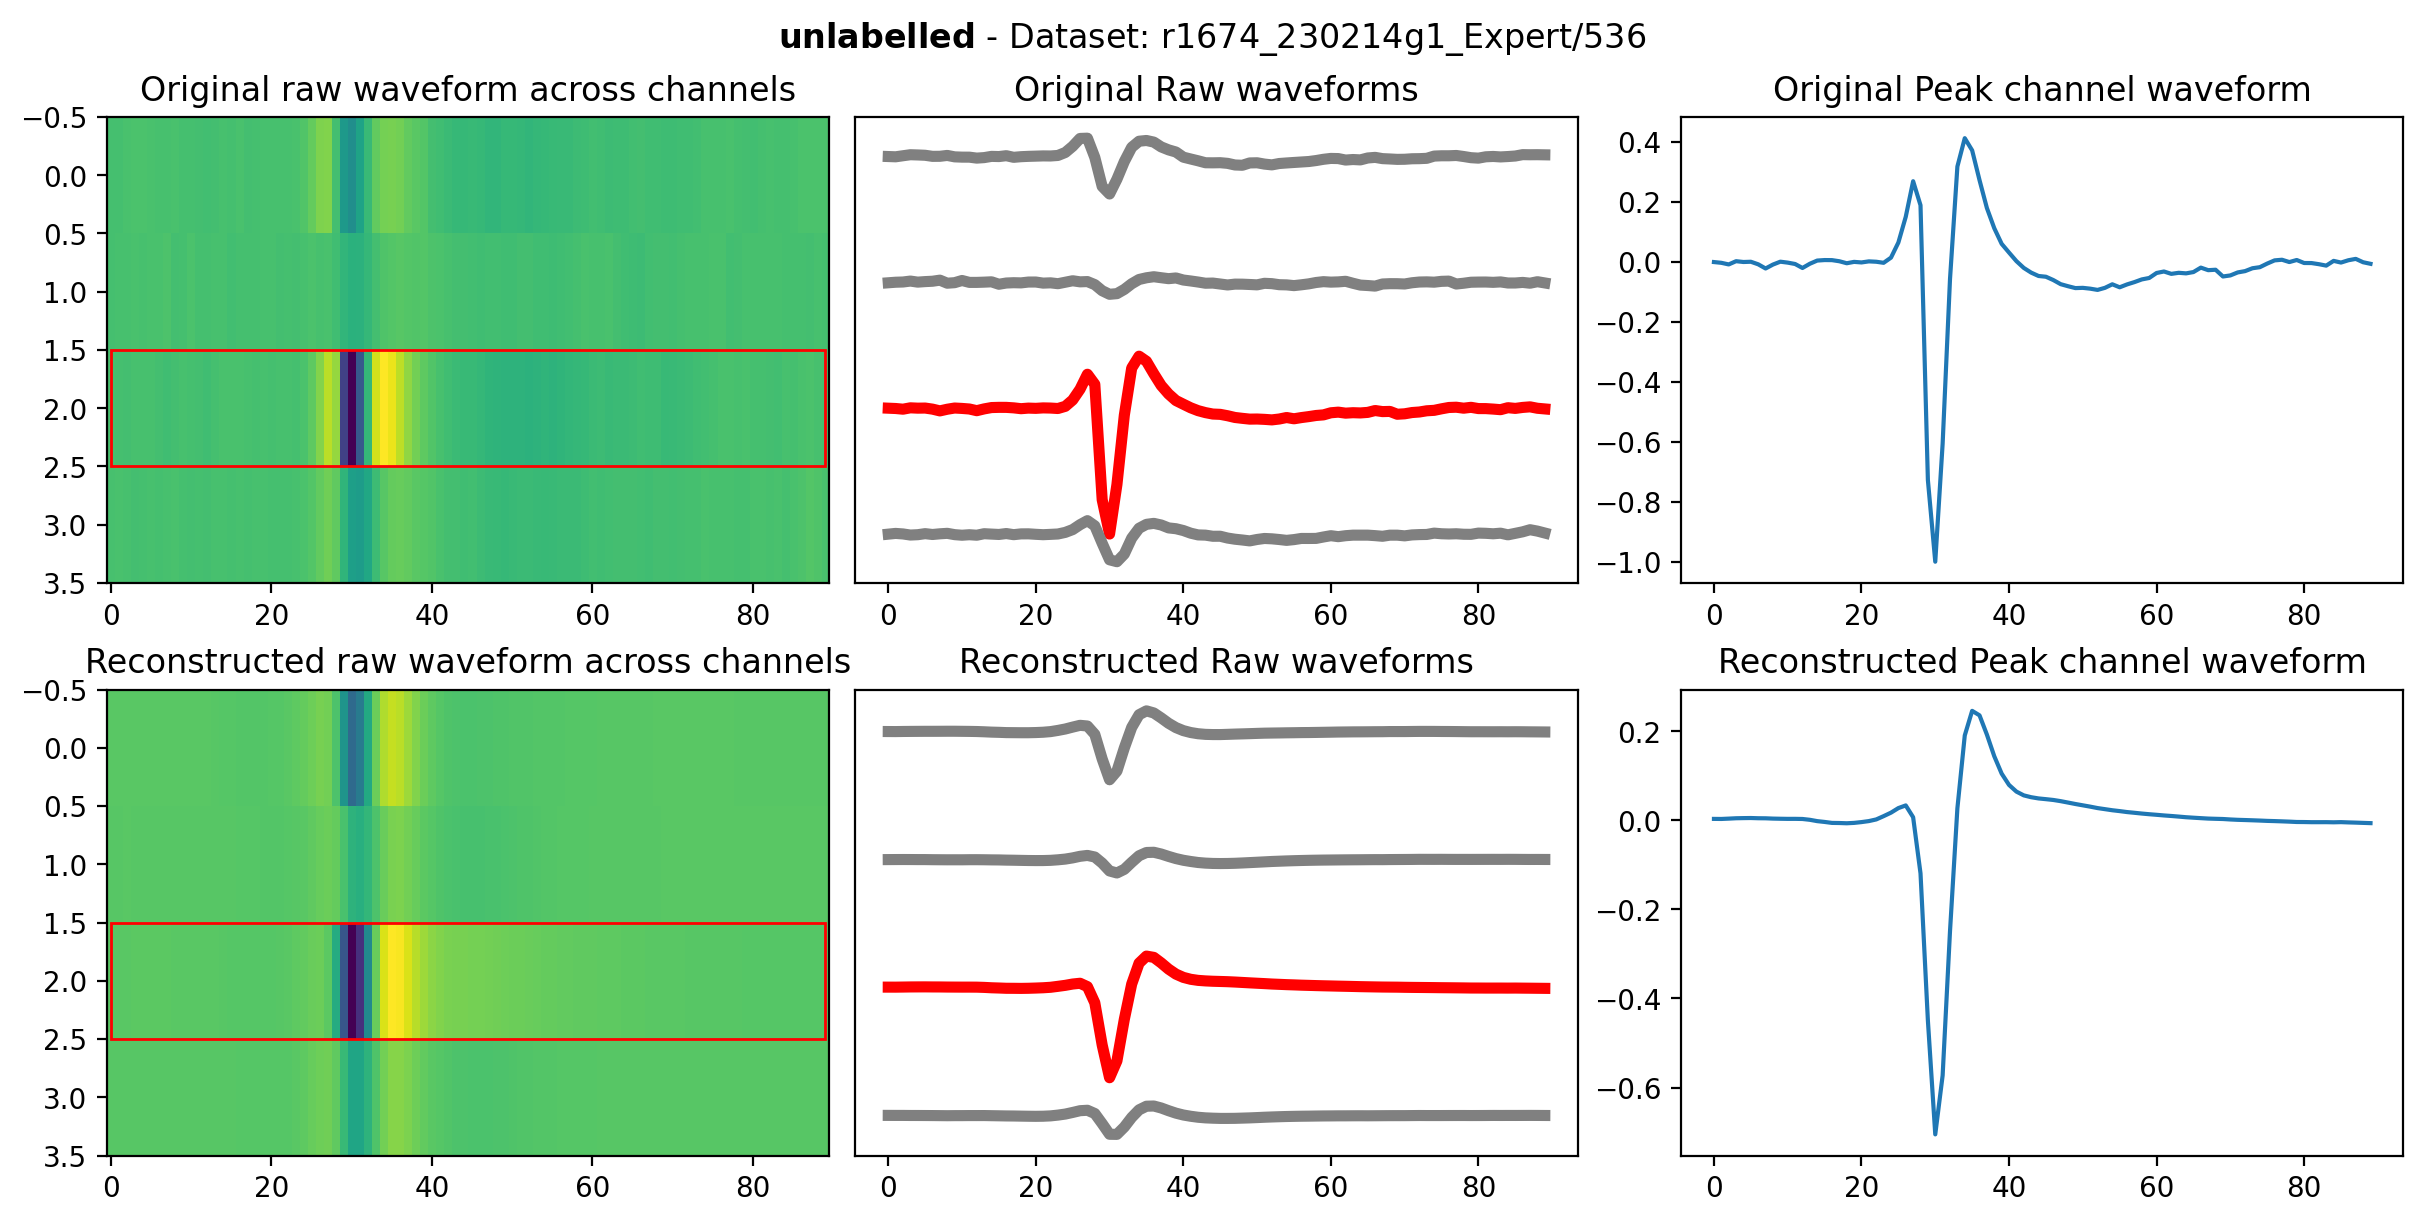

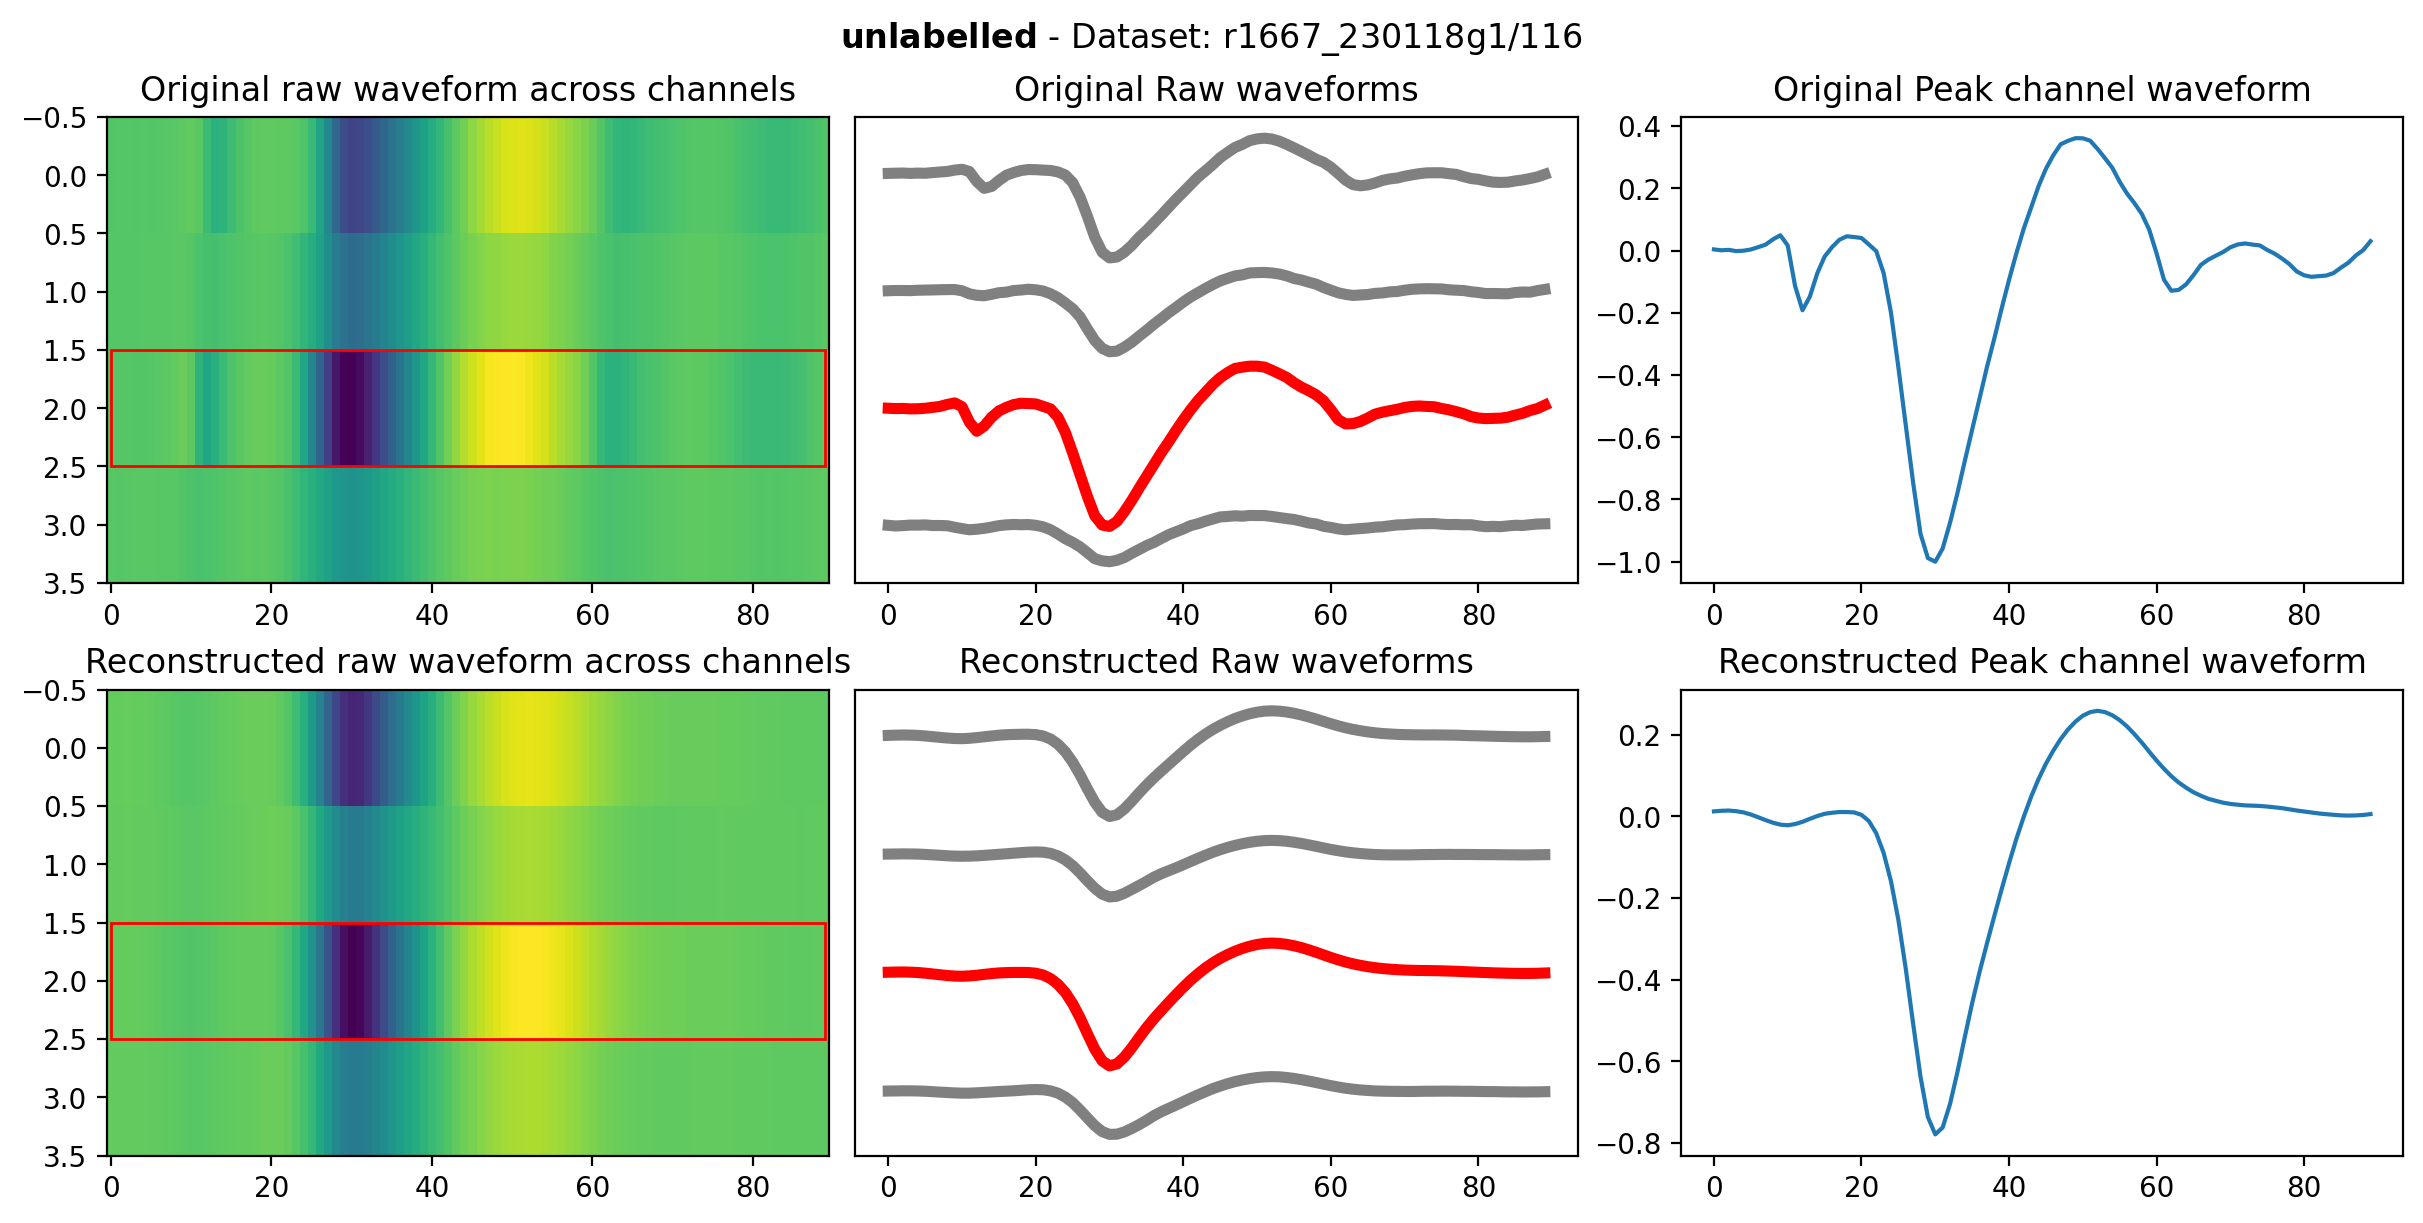

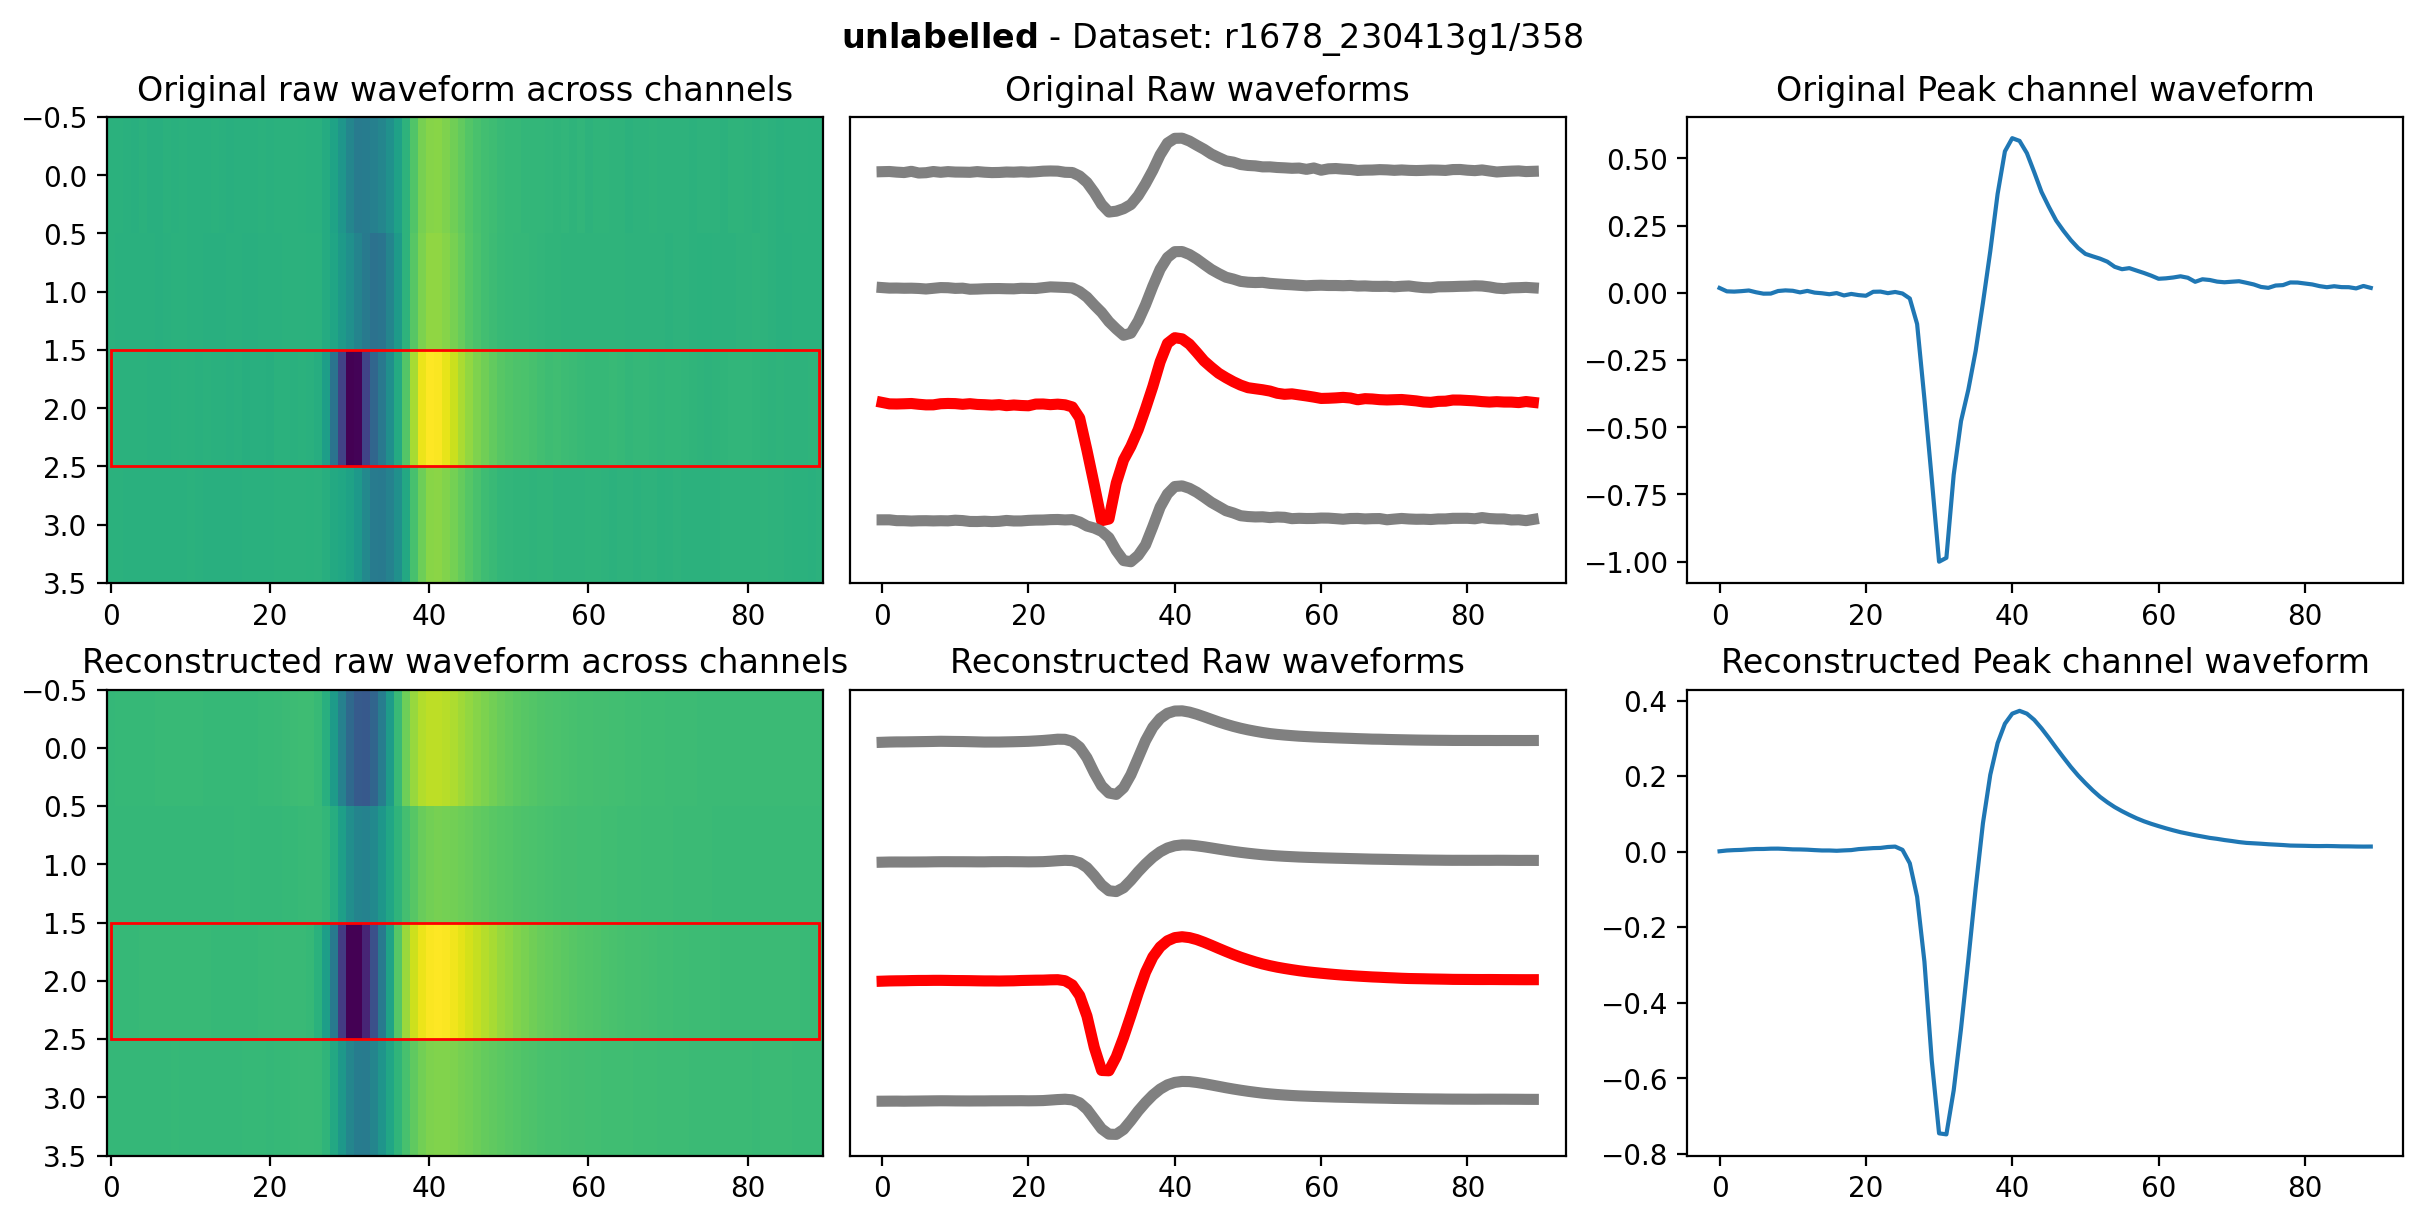

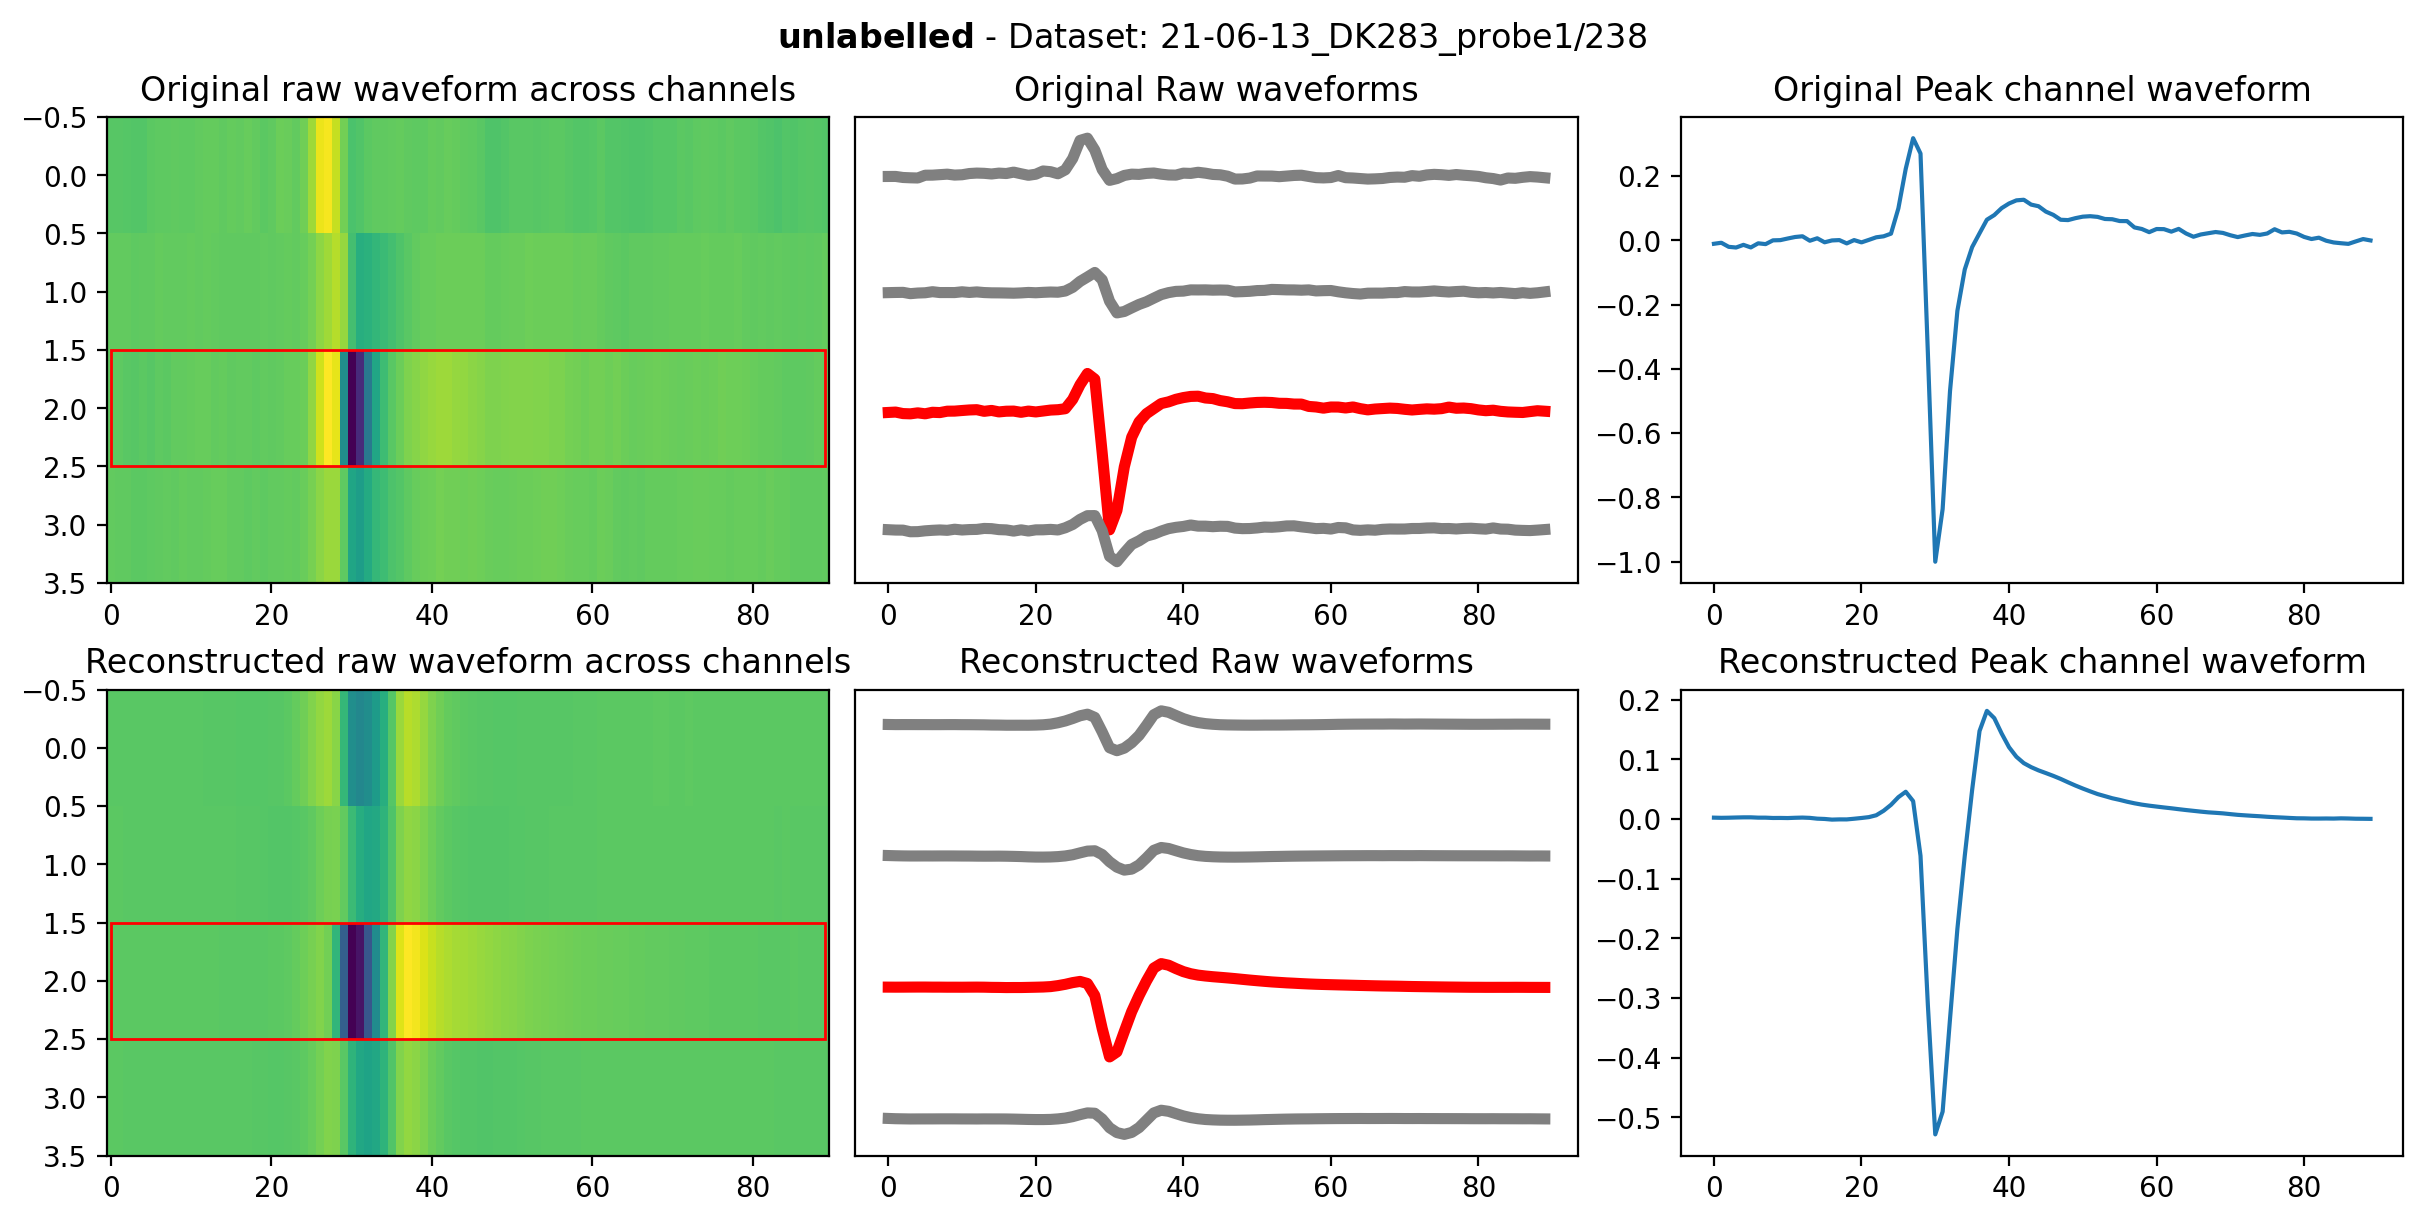

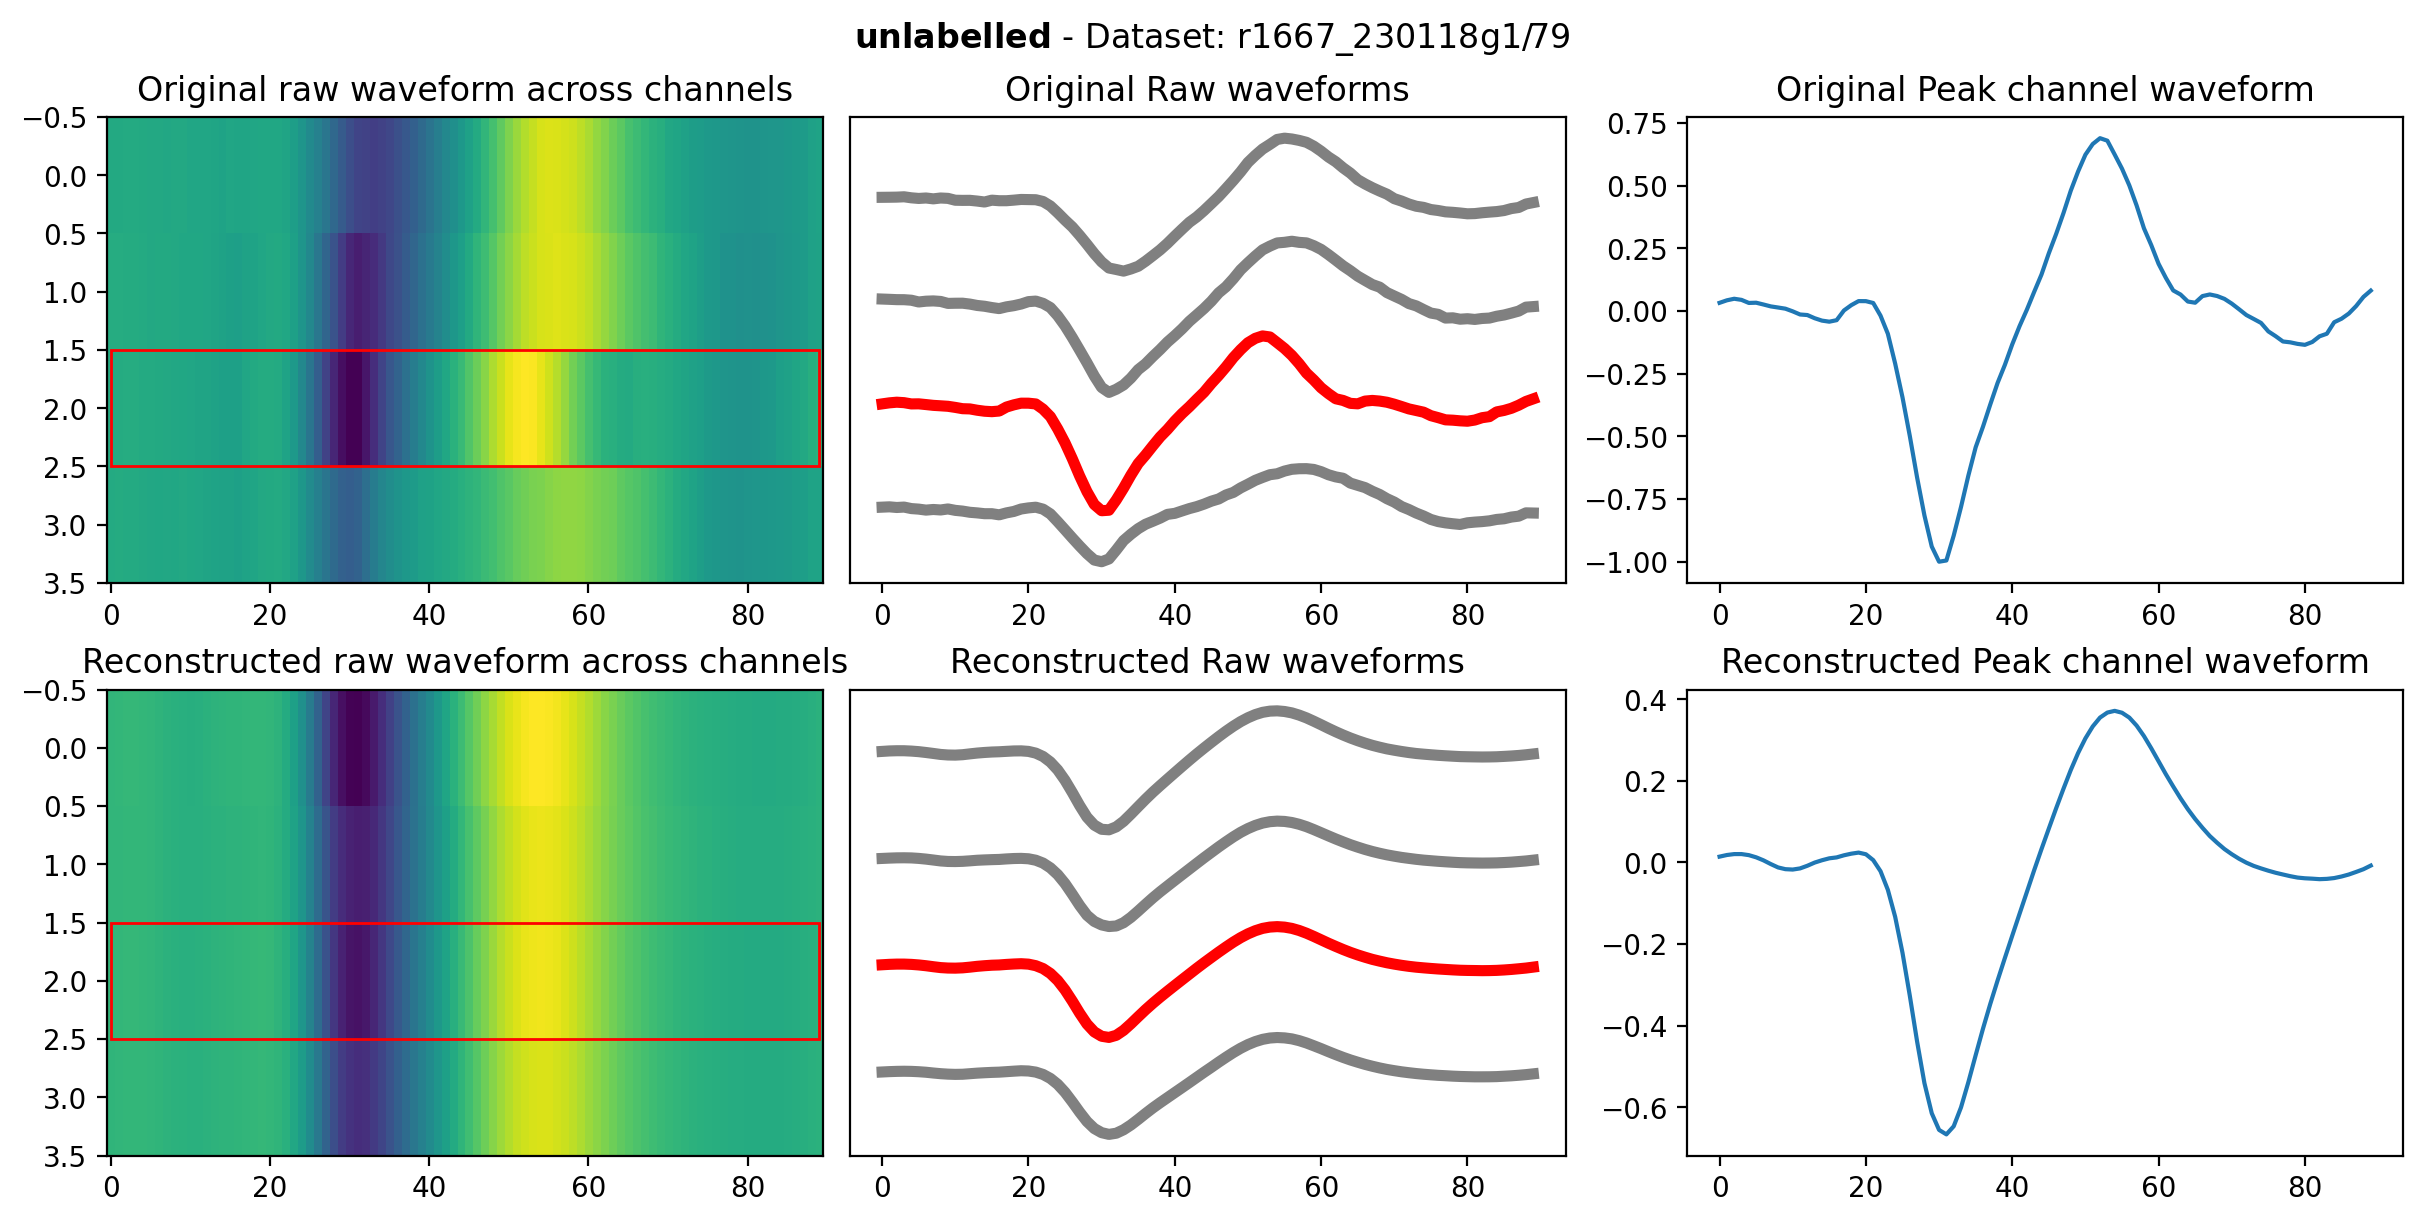

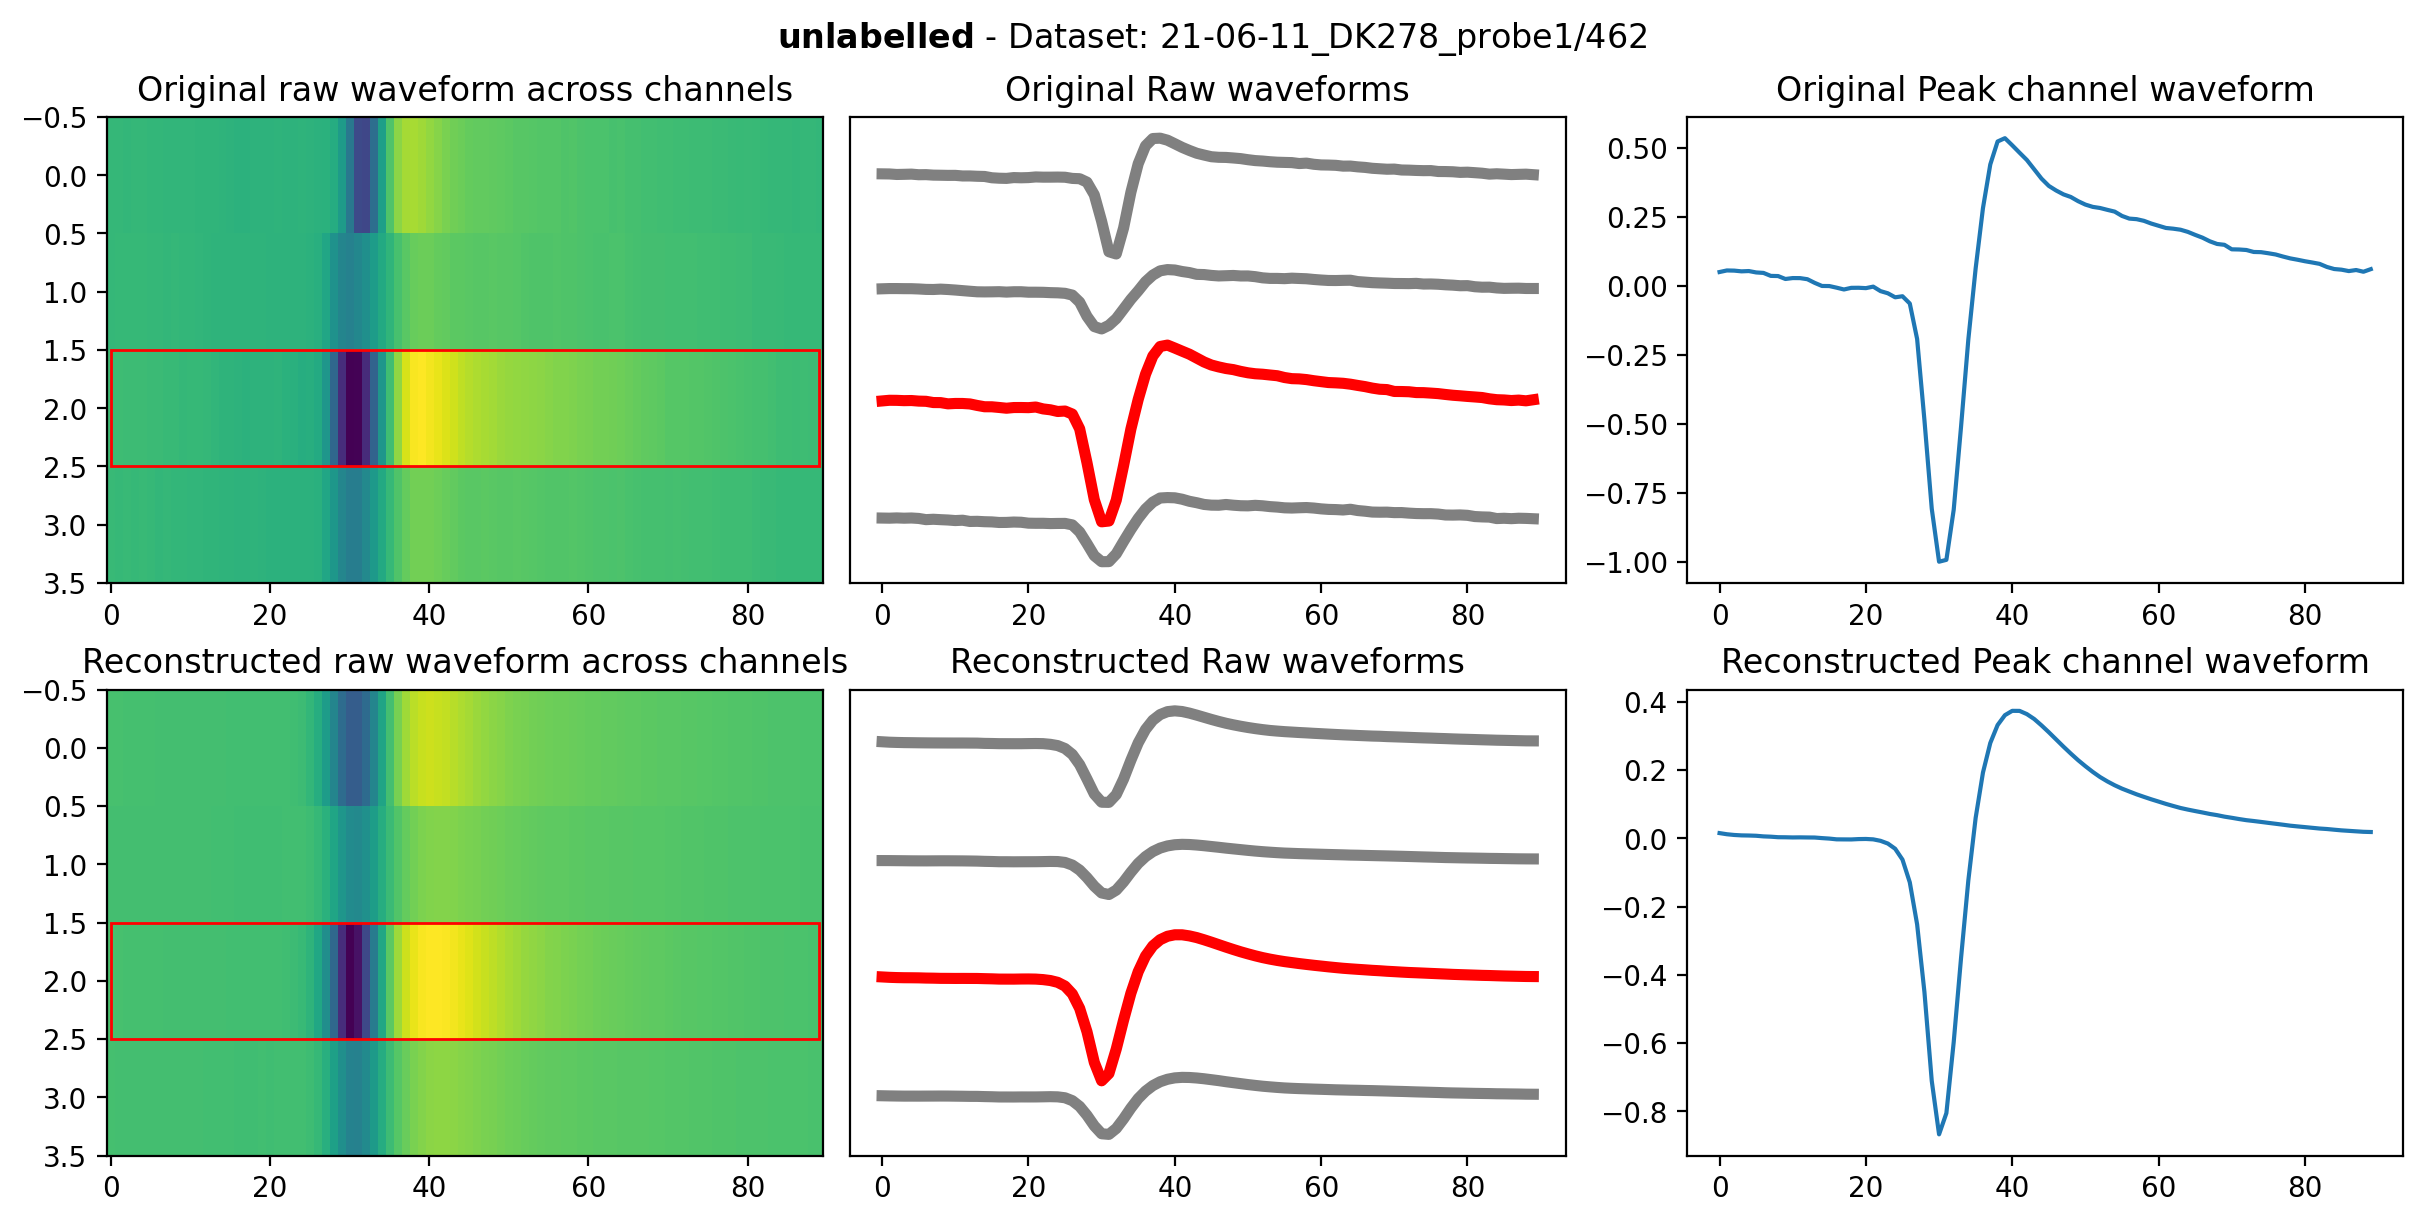

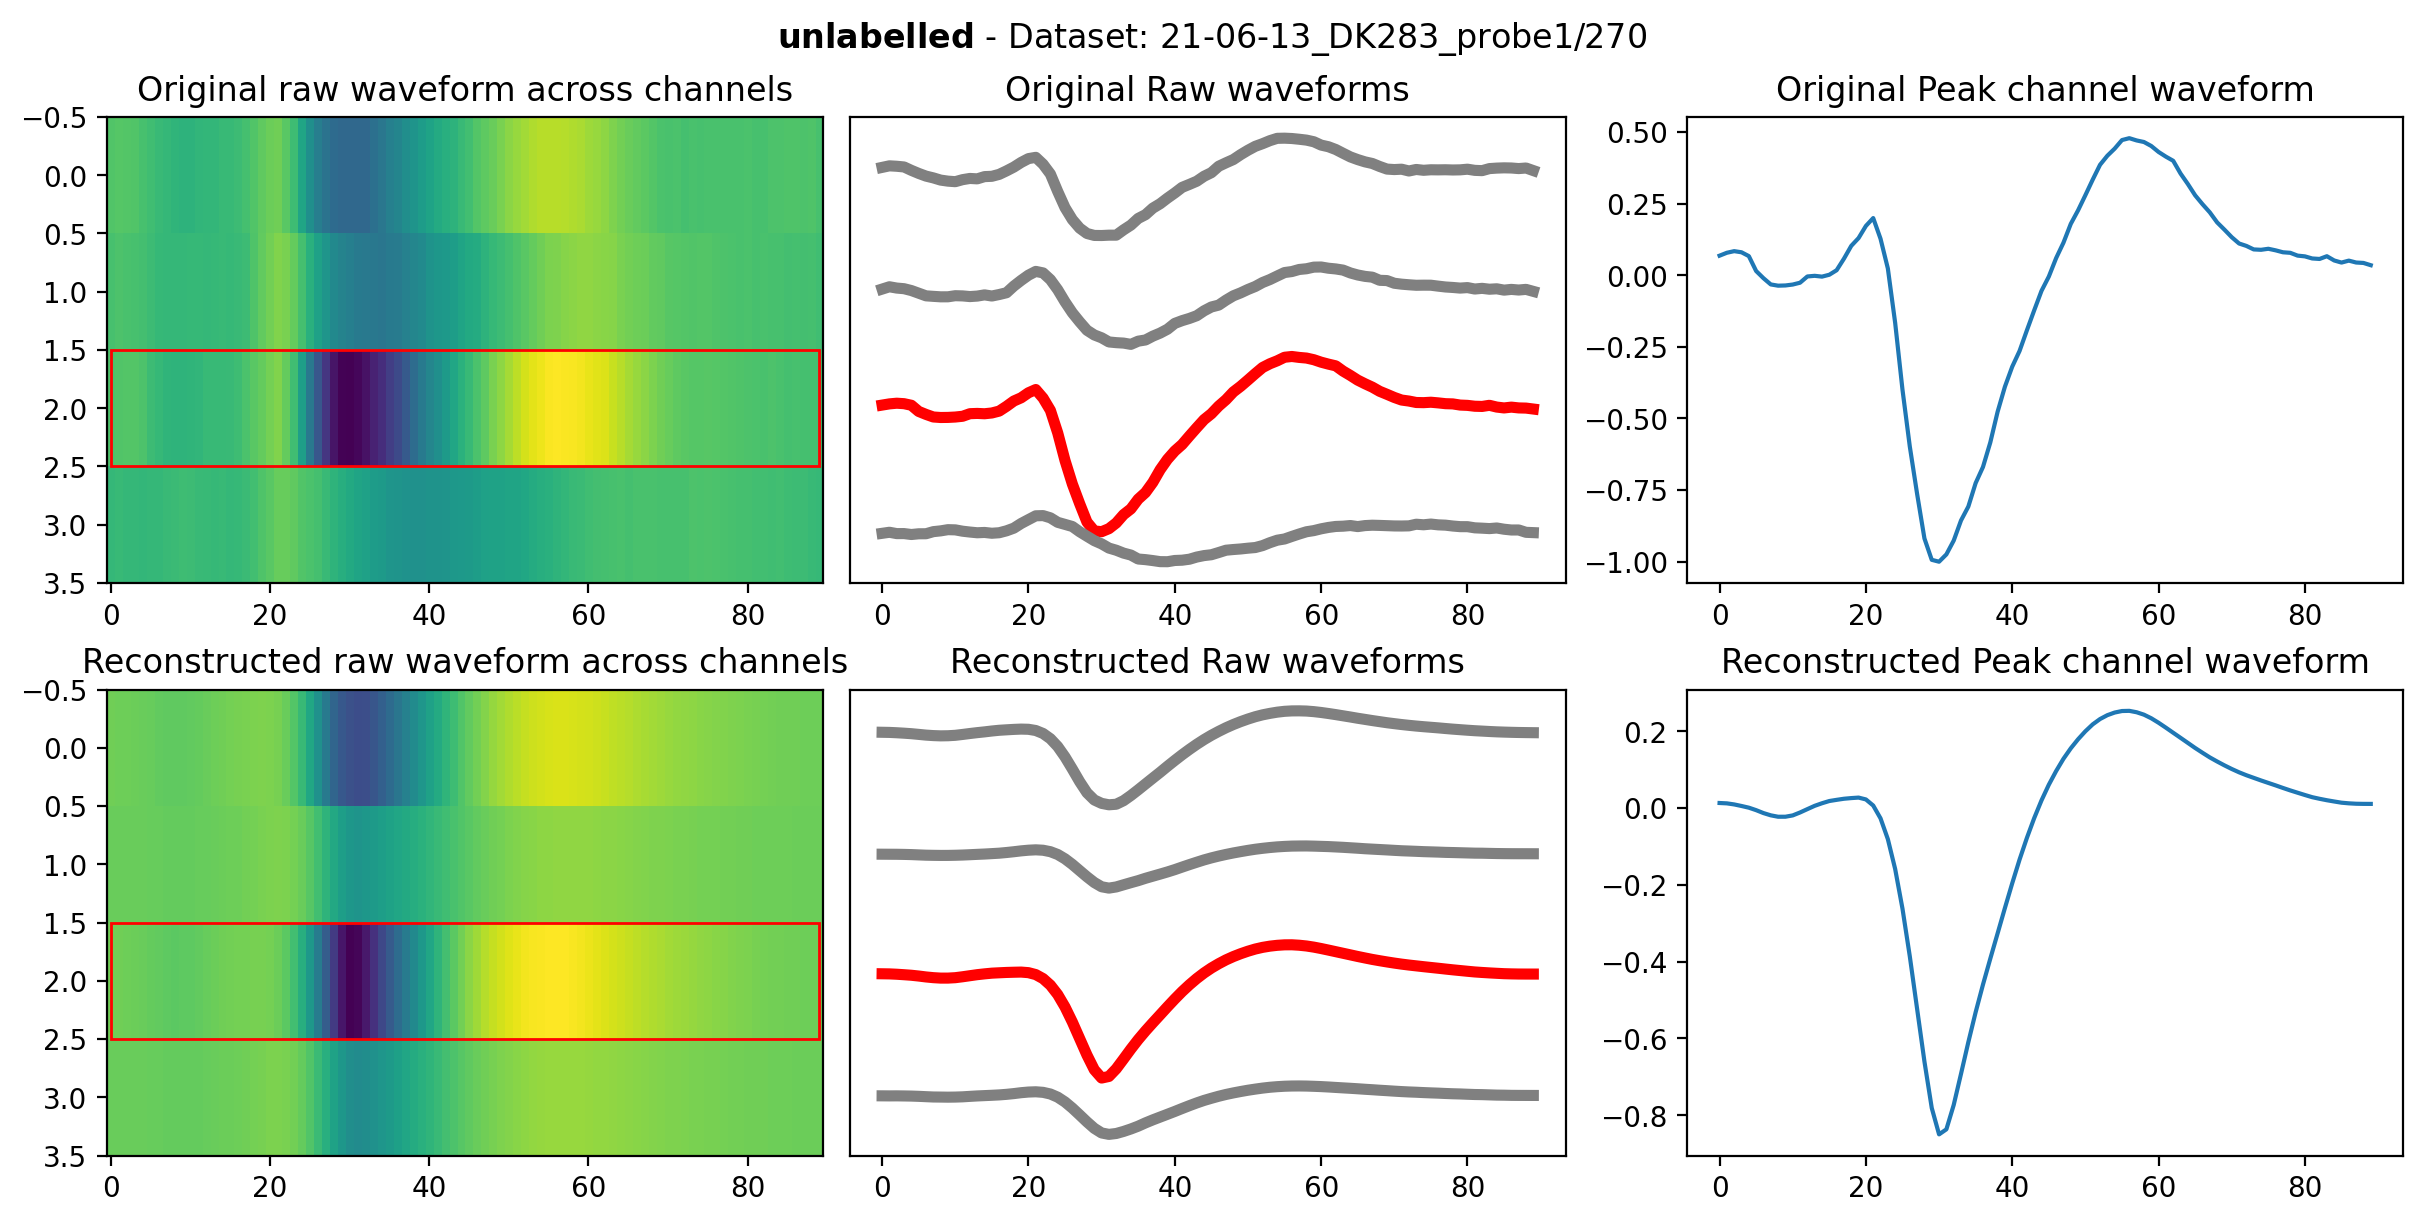

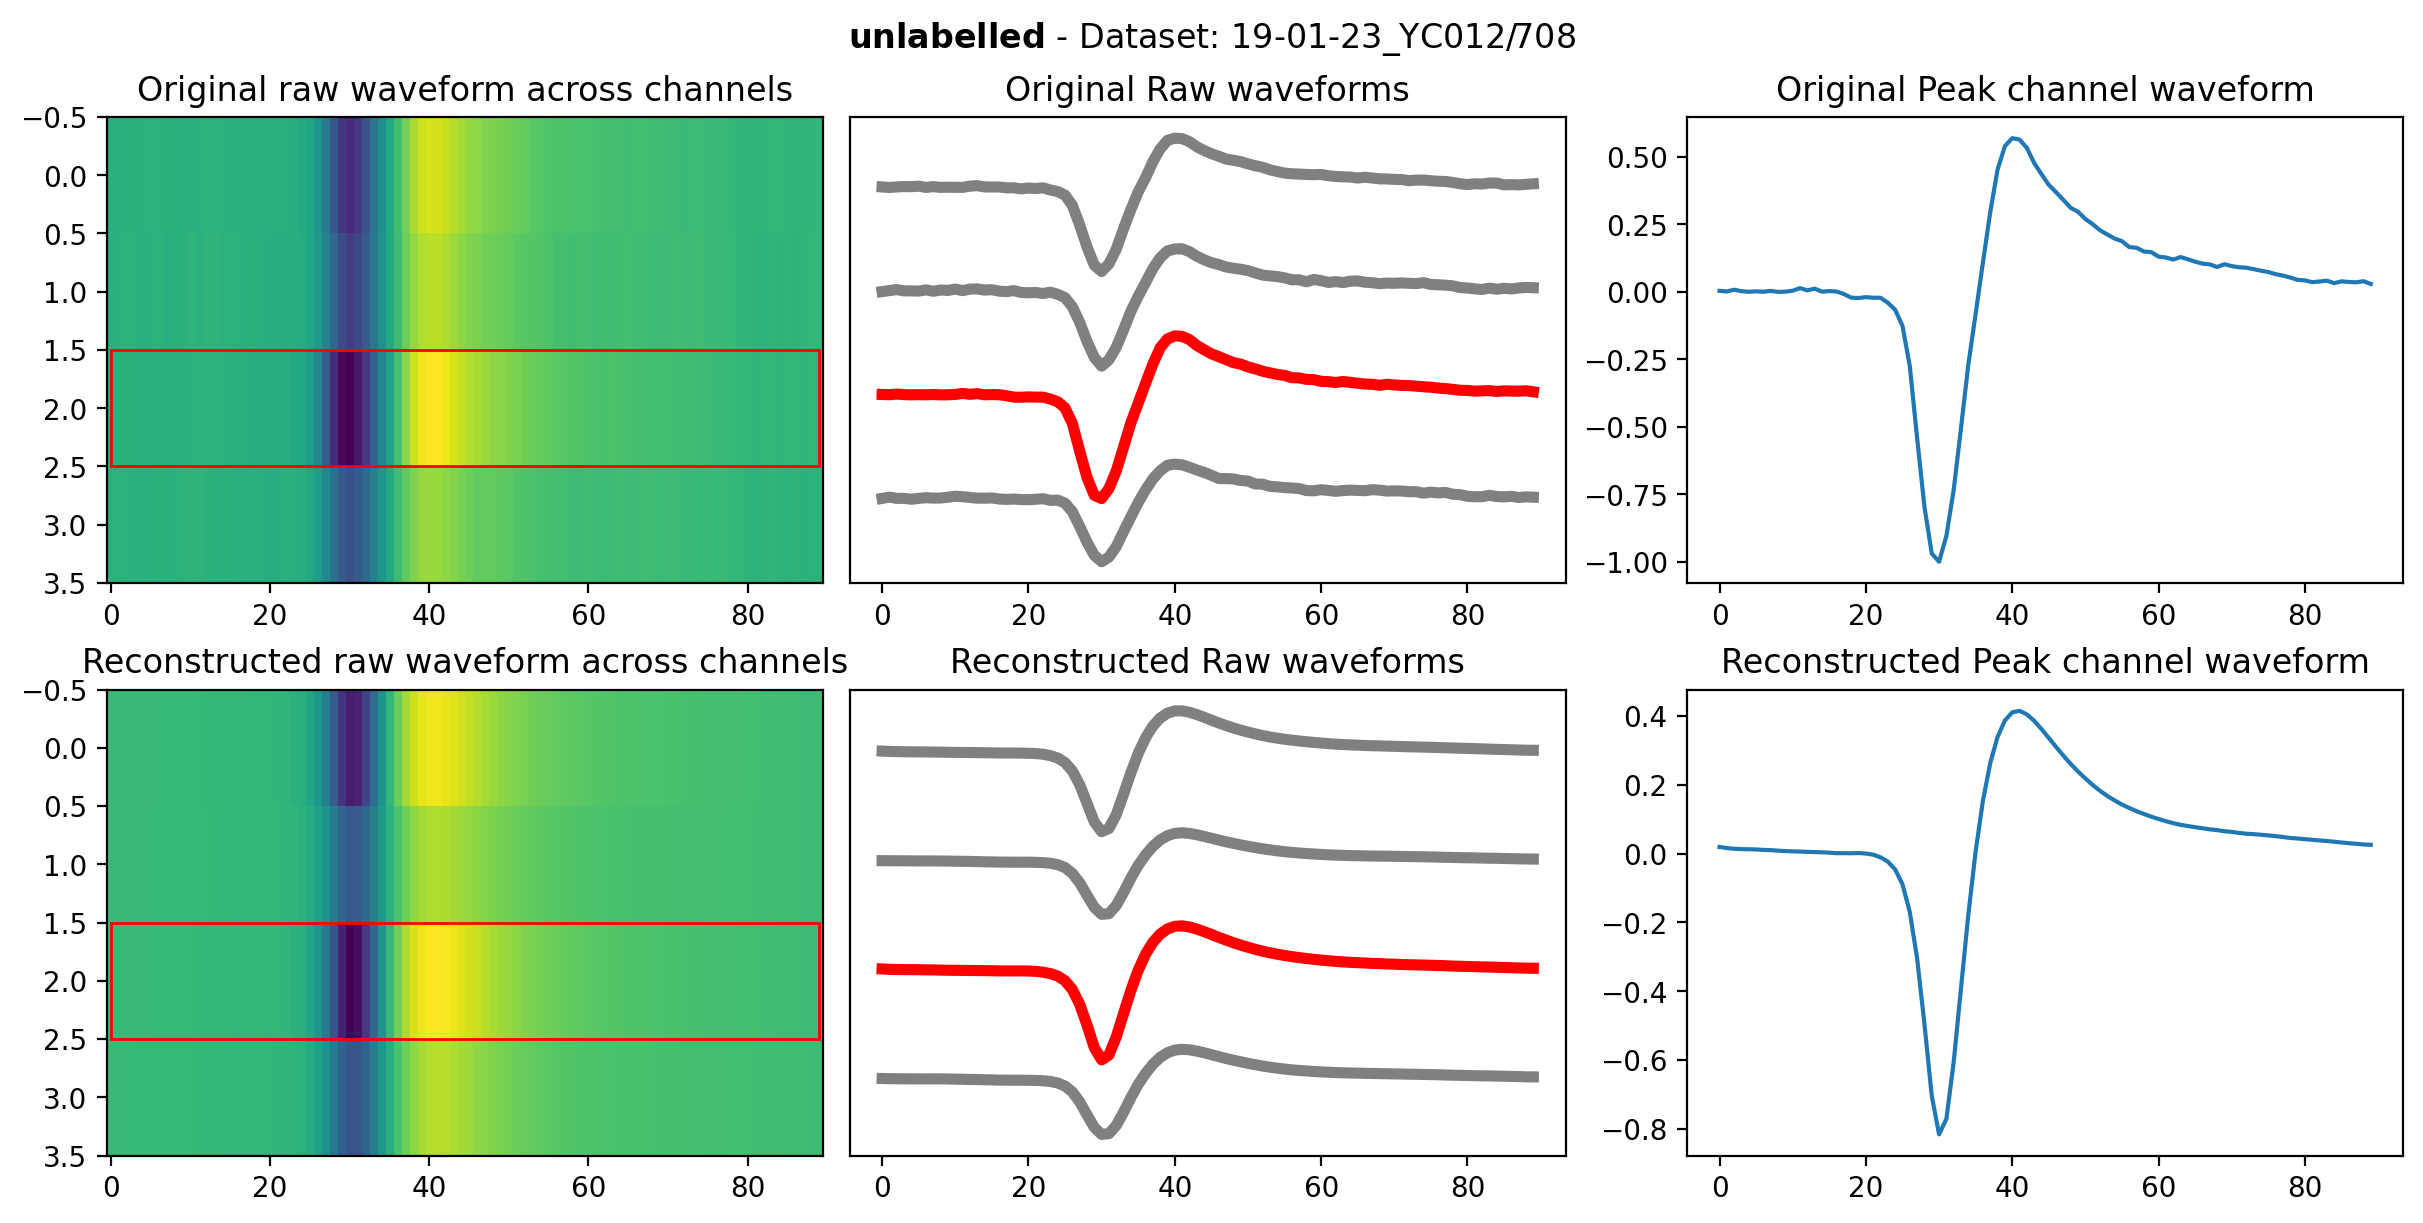

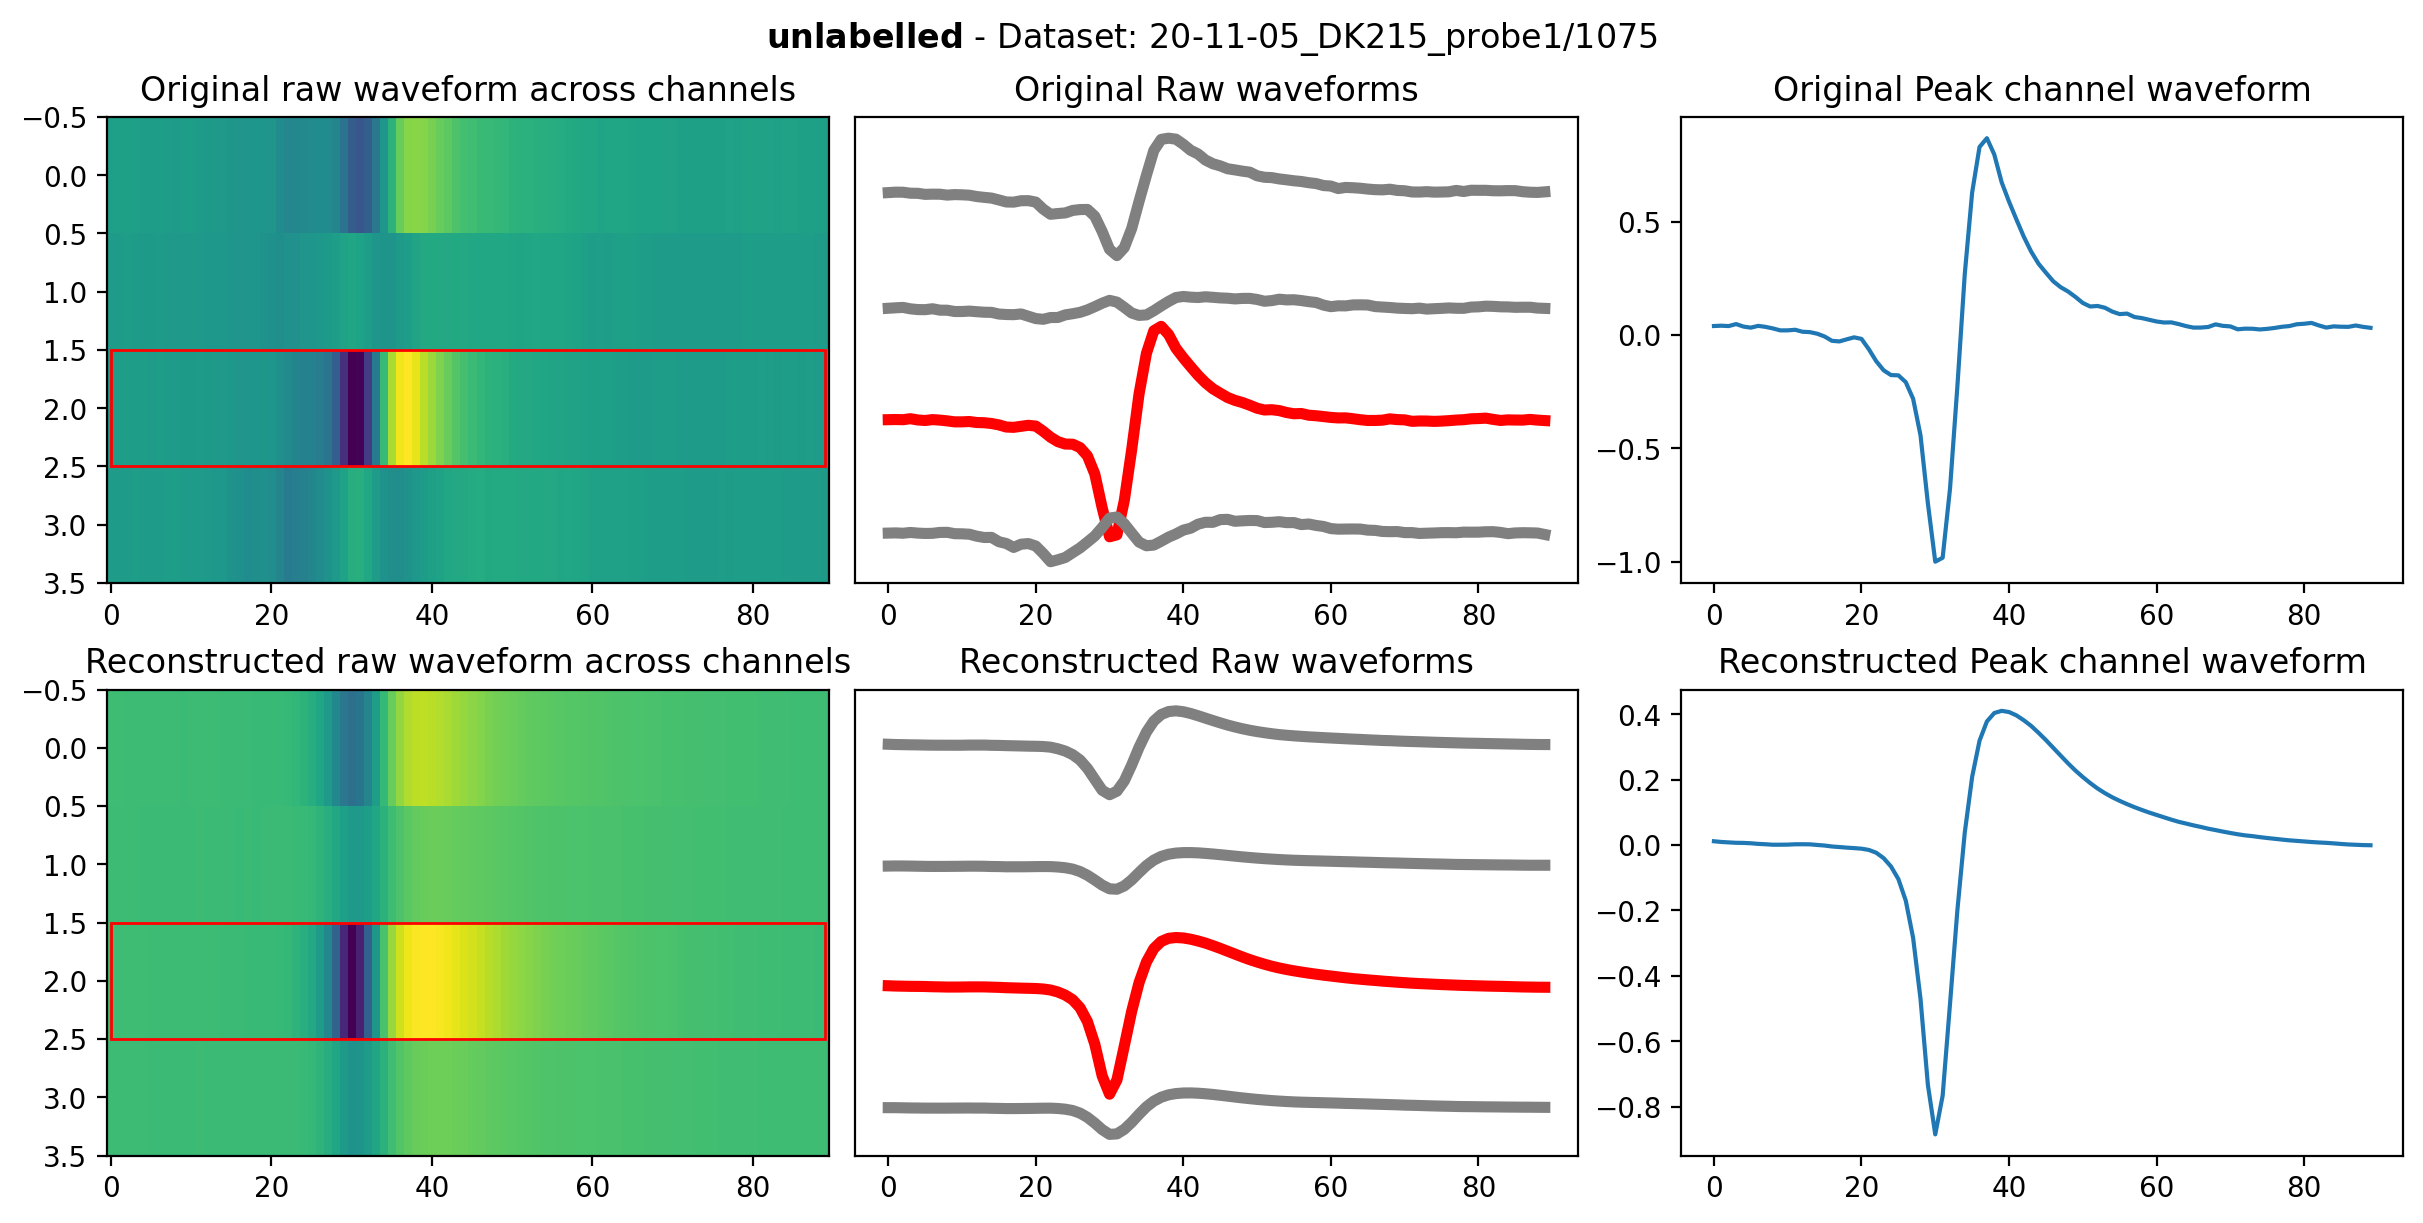

In [25]:
full_dataset = np.concatenate(
    (BASE_DATASET.targets[:, None].astype(int), waveforms), axis=1
)
dataset_info = BASE_DATASET.info

plot_random_reconstruction(full_dataset, enc, dec, dataset_info, n_neurons=10)

In [21]:
raise ValueError("Stop here")

ValueError: Stop here

In [26]:
torch.save(
    enc.state_dict(),
    os.path.join(
        Path.home(), ".npyx_c4_resources", "vaes", "wvf_multichannel_encoder.pt"
    ),
)
torch.save(
    dec.state_dict(),
    os.path.join(
        Path.home(), ".npyx_c4_resources", "vaes", "wvf_multichannel_decoder.pt"
    ),
)

In [23]:
dataset = CerebellumDataset(
    waveforms, BASE_DATASET.targets, BASE_DATASET.spikes_list, transform=None
)
plotting_train_loader = data.DataLoader(dataset, batch_size=len(dataset))
X_random_batch, y_random_batch = next(iter(plotting_train_loader))

In [24]:
X_random_batch = X_random_batch.reshape(-1, 1, N_CHANNELS, WAVEFORM_SAMPLES).to("cpu")

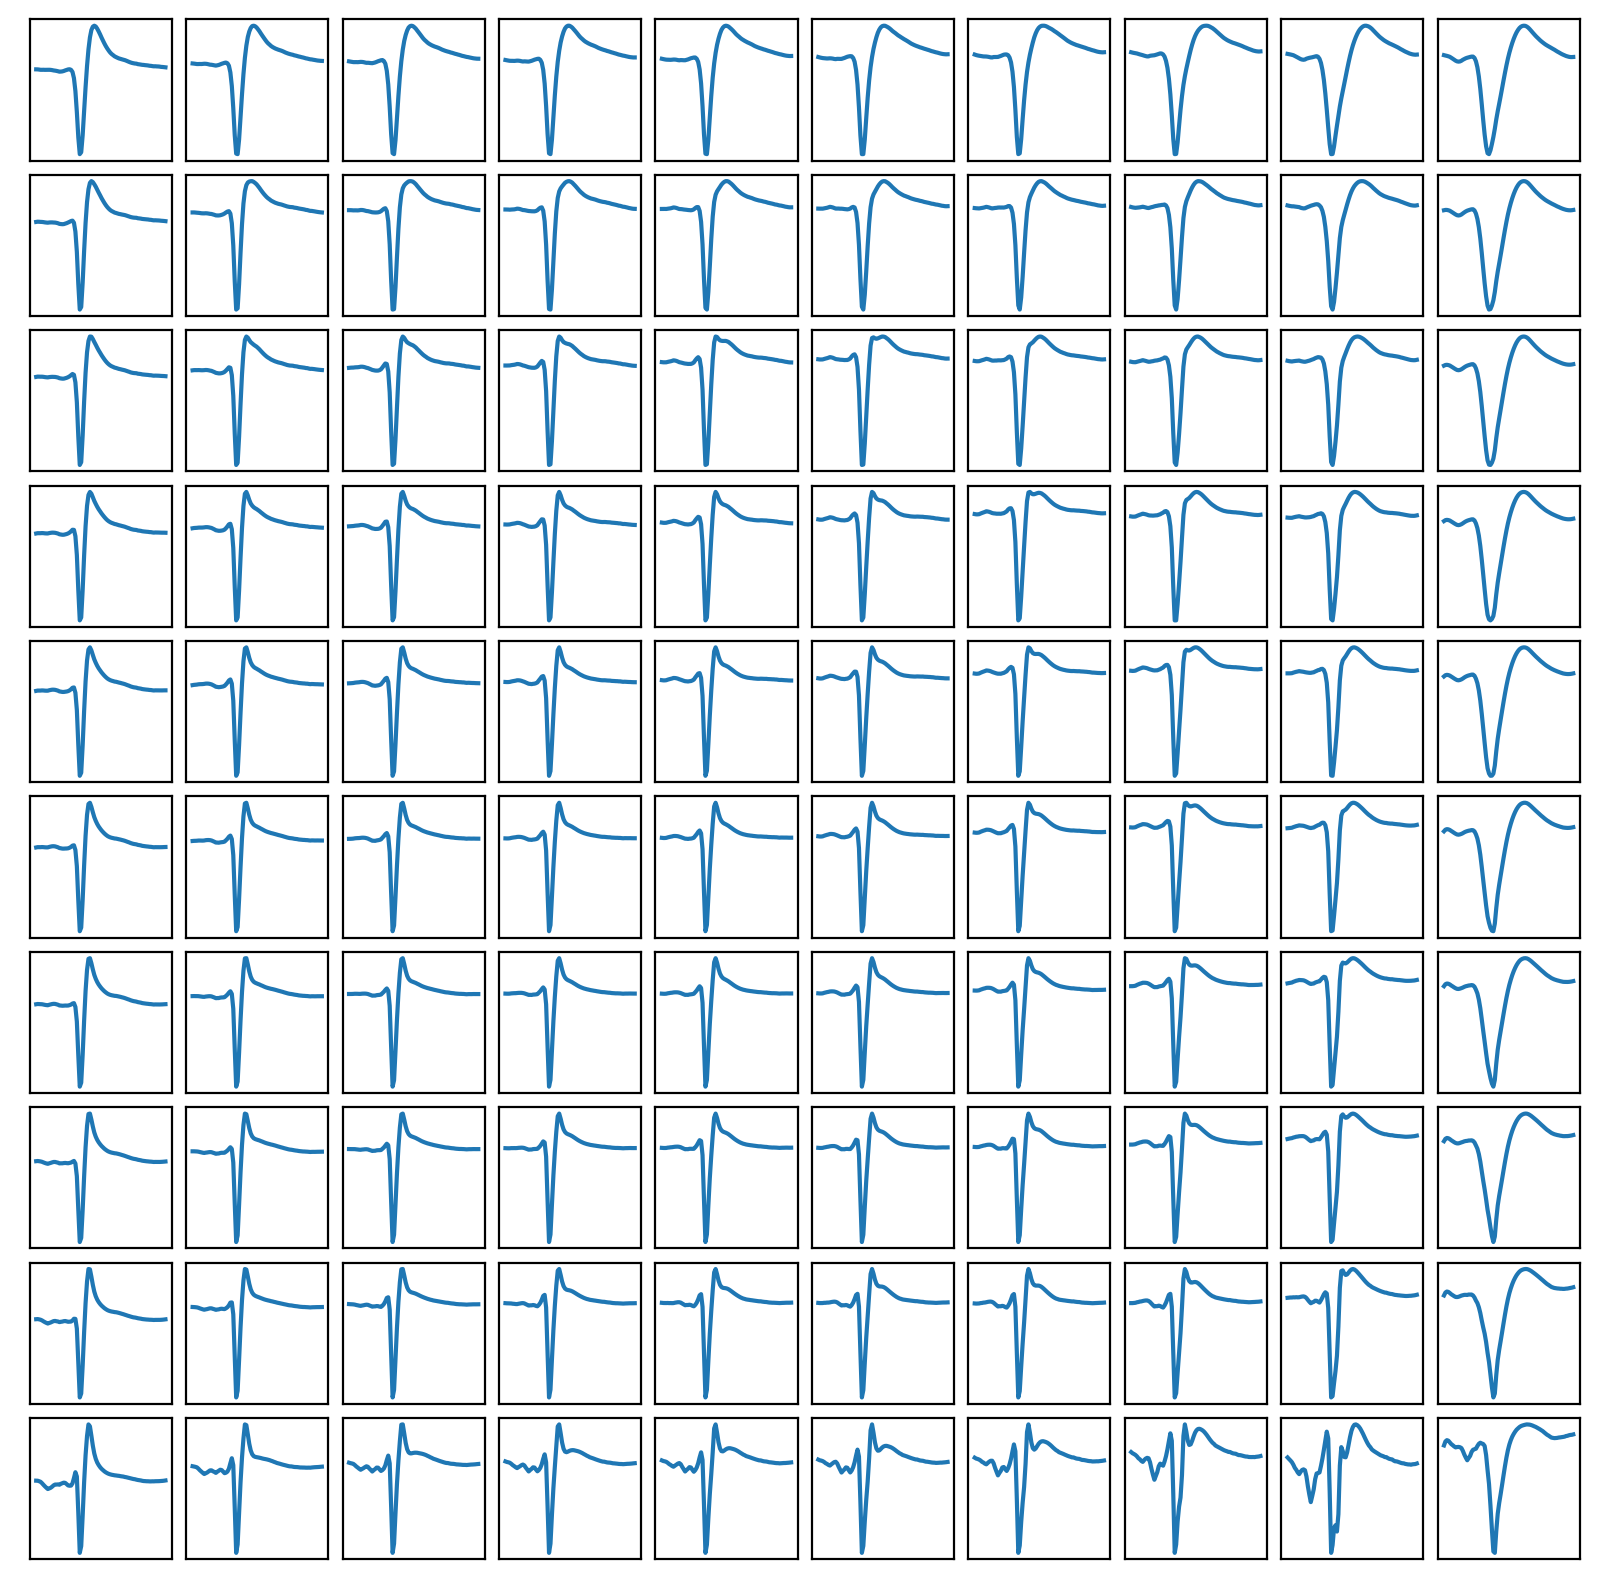

In [26]:
def plot_2d_latent(
    encoder, decoder, random_batch, n=15, save=False, std=1, channel=None
):
    """If this is a 2d latent space, it plots the latent space
    If the latent space is larger than 2d, then it plots a 2d cross-section"""
    # Take the first 2 right singular vectors from the SVD of the mean latent space vector over a random batch
    W = torch.linalg.svd(encoder(random_batch).mean).Vh[:2]
    # Take the inverse cdf of n evenly spaced points from 0 to 1
    points = dist.Normal(0, std).icdf(torch.linspace(0.01, 0.99, n))
    # Create a nxn meshgrid with the points
    XX, YY = torch.meshgrid(points, points, indexing="ij")
    # Stack the meshgrid, then reshape to 2 x xxyy. Then transpose so final is xxyy x 2
    XXYY = torch.stack((XX, YY)).reshape(2, -1).T
    # Get the decoder output of W transformed by that matrix. W is 2 x batch_size
    with torch.no_grad():
        out = (
            decoder(XXYY @ W)
            .reshape(-1, 1, N_CHANNELS, WAVEFORM_SAMPLES)
            .numpy()
            .squeeze()
        )

    fig = plt.figure(figsize=(10, 10))
    gs = fig.add_gridspec(ncols=n, nrows=n, hspace=0.1, wspace=0.1)
    axs = gs.subplots()
    count = 0
    if channel is None:
        channel = N_CHANNELS // 2
    else:
        assert channel in range(
            0, out.shape[1]
        ), "Channel must be in range 0 to {}".format(out.shape[1])
    for i in range(n):
        for j in range(n):
            axs[i, j].plot(out[count, channel, :])
            axs[i, j].set_yticks([])
            axs[i, j].set_xticks([])
            axs[i, j].label_outer()
            count += 1

    if save:
        plt.savefig(f"wvf_latent_space{n}.pdf")
    plt.show()


plot_2d_latent(enc.cpu(), dec.cpu(), X_random_batch, n=10, std=1, save=False, channel=5)